In [30]:
#!/usr/bin/env python3

from pywarpx import picmi

# Physical constants
c = picmi.constants.c
q_e = picmi.constants.q_e

# Number of time steps
max_steps = 150

# Number of cells
nx = 32
ny = 32
nz = 256

# Physical domain
xmin = -30e-06
xmax =  30e-06
ymin = -30e-06
ymax =  30e-06
zmin = -56e-06
zmax =  12e-06

# Domain decomposition
max_grid_size = 64
blocking_factor = 32

# Create grid
grid = picmi.Cartesian3DGrid(
    number_of_cells = [nx, ny, nz],
    lower_bound = [xmin, ymin, zmin],
    upper_bound = [xmax, ymax, zmax],
    lower_boundary_conditions = ['periodic', 'periodic', 'dirichlet'],
    upper_boundary_conditions = ['periodic', 'periodic', 'dirichlet'],
    lower_boundary_conditions_particles = ['periodic', 'periodic', 'absorbing'],
    upper_boundary_conditions_particles = ['periodic', 'periodic', 'absorbing'],
    moving_window_velocity = [0., 0., c],
    warpx_max_grid_size = max_grid_size,
    warpx_blocking_factor = blocking_factor)

# Particles: plasma electrons
plasma_density = 2e23
plasma_xmin = -20e-06
plasma_ymin = -20e-06
plasma_zmin = 0
plasma_xmax = 20e-06
plasma_ymax = 20e-06
plasma_zmax = None
uniform_distribution = picmi.UniformDistribution(
    density = plasma_density,
    lower_bound = [plasma_xmin, plasma_ymin, plasma_zmin],
    upper_bound = [plasma_xmax, plasma_ymax, plasma_zmax],
    fill_in = True)
electrons = picmi.Species(
    particle_type = 'electron',
    name = 'electrons',
    initial_distribution = uniform_distribution,
    warpx_add_int_attributes = {'regionofinterest': "(z>12.0e-6) * (z<13.0e-6)"},
    warpx_add_real_attributes = {'initialenergy': "ux*ux + uy*uy + uz*uz"})

# Particles: beam electrons
q_tot = 1e-12
x_m = 0.
y_m = 0.
z_m = -28e-06
x_rms = 0.5e-06
y_rms = 0.5e-06
z_rms = 0.5e-06
ux_m = 0.
uy_m = 0.
uz_m = 500.
ux_th = 2.
uy_th = 2.
uz_th = 50.
gaussian_bunch_distribution = picmi.GaussianBunchDistribution(
    n_physical_particles = q_tot / q_e,
    rms_bunch_size = [x_rms, y_rms, z_rms],
    rms_velocity = [c*ux_th, c*uy_th, c*uz_th],
    centroid_position = [x_m, y_m, z_m],
    centroid_velocity = [c*ux_m, c*uy_m, c*uz_m])
beam = picmi.Species(
    particle_type = 'electron',
    name = 'beam',
    initial_distribution = gaussian_bunch_distribution)

# Laser
e_max = 16e12
position_z = 9e-06
profile_t_peak = 30.e-15
profile_focal_distance = 100e-06
laser = picmi.GaussianLaser(
    wavelength = 0.8e-06,
    waist = 5e-06,
    duration = 15e-15,
    focal_position = [0, 0, profile_focal_distance + position_z],
    centroid_position = [0, 0, position_z - c*profile_t_peak],
    propagation_direction = [0, 0, 1],
    polarization_direction = [0, 1, 0],
    E0 = e_max,
    fill_in = False)
laser_antenna = picmi.LaserAntenna(
    position = [0., 0., position_z],
    normal_vector = [0, 0, 1])

# Electromagnetic solver
solver = picmi.ElectromagneticSolver(
    grid = grid,
    method = 'Yee',
    cfl = 1.,
    divE_cleaning = 0)

# Diagnostics
diag_field_list = ['B', 'E', 'J', 'rho']
particle_diag = picmi.ParticleDiagnostic(
    name = 'diag1',
    period = 1,
    write_dir = '.',
    warpx_file_prefix = 'Python_LaserAcceleration_plt')
field_diag = picmi.FieldDiagnostic(
    name = 'diag1',
    grid = grid,
    period = 1,
    data_list = diag_field_list,
    write_dir = '.',
    warpx_file_prefix = 'Python_LaserAcceleration_plt')

# Set up simulation
sim = picmi.Simulation(
    solver = solver,
    max_steps = max_steps,
    verbose = 1,
    particle_shape = 'cubic',
    warpx_use_filter = 1,
    warpx_serialize_initial_conditions = 1,
    warpx_do_dynamic_scheduling = 0)

# Add plasma electrons
sim.add_species(
    electrons,
    layout = picmi.GriddedLayout(grid = grid, n_macroparticle_per_cell = [1, 1, 1]))

# Add beam electrons
sim.add_species(
    beam,
    layout = picmi.PseudoRandomLayout(grid = grid, n_macroparticles = 100))

# Add laser
sim.add_laser(
    laser,
    injection_method = laser_antenna)

# Add diagnostics
sim.add_diagnostic(particle_diag)
sim.add_diagnostic(field_diag)

# Write input file that can be used to run with the compiled version
sim.write_input_file(file_name = 'inputs_3d_picmi')

# Initialize inputs and WarpX instance
sim.initialize_inputs()
sim.initialize_warpx()

# Advance simulation until last time step
sim.step(max_steps)

Initializing AMReX (24.06)...
OMP initialized with 2 OMP threads
AMReX (24.06) initialized
PICSAR (23.09)
WarpX (Unknown)

    __        __             __  __
    \ \      / /_ _ _ __ _ __\ \/ /
     \ \ /\ / / _` | '__| '_ \\  /
      \ V  V / (_| | |  | |_) /  \
       \_/\_/ \__,_|_|  | .__/_/\_\
                        |_|

Level 0: dt = 8.687655226e-16 ; dx = 1.875e-06 ; dy = 1.875e-06 ; dz = 2.65625e-07

Grids Summary:
  Level 0   4 grids  262144 cells  100 % of domain
            smallest grid: 32 x 32 x 64  biggest grid: 32 x 32 x 64

-------------------------------------------------------------------------------
--------------------------- MAIN EM PIC PARAMETERS ----------------------------
-------------------------------------------------------------------------------
Precision:            | DOUBLE
Particle precision:   | DOUBLE
Geometry:             | 3D (XYZ)
Operation mode:       | Electromagnetic
                      | - vacuum
-------------------------------------------

FILE #1 LOADED...
FILE #2 LOADED...
FILE #3 LOADED...
FILE #4 LOADED...
FILE #5 LOADED...
Frame gathering complete!


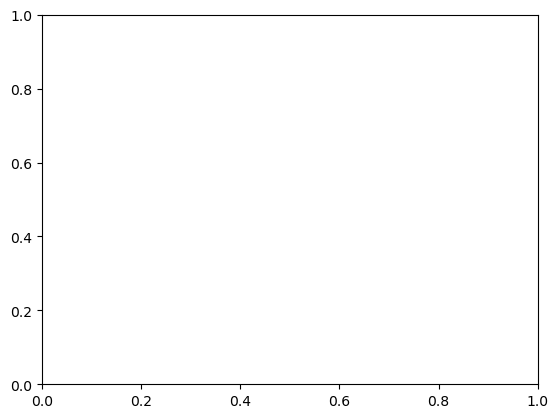

In [4]:
#!/usr/bin/env python3

# Copyright 2023 The WarpX Community
#
# This file is part of WarpX.
#
# Authors: Axel Huebl
# License: BSD-3-Clause-LBNL
#
# This is a script plots the wakefield of an LWFA simulation.

import sys
import os 
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
import yt

yt.funcs.mylog.setLevel(50)

# fig, ax = plt.subplots()  # plt.subplots() creates a new figure and ax is a variable set to it


def plot_lwfa(file_list):
    fig, ax = plt.subplots()  # plt.subplots() creates a new figure and ax is a variable set to it
    
    ims = []  # a list of lists in which each index is a frame of the animation
    file_index = 0
    #for file_index in range(len(file_list)):
    for file_index, fn in enumerate(file_list):
    
        # this will be the name of the plot file
        fn = file_list[file_index]  # give file name to variable 'fn' stands for 'file name'

        # Read the file
        ds = yt.load(fn)  # load the above file into variable ds

        # plot the laser field and absolute density
        fields = ["Ey", "rho"]  # a list of fields representing physical quantities. Here it is electric field and density
        normal = "y"  # this is the axis that is perpendicular to the 2D plane
        sl = yt.SlicePlot(ds, normal=normal, fields=fields)  # make this thing 2D
        for field in fields:  # go through the list of physical quantities
            sl.set_log(field, False)  # don't do any logarithmic scaling

        sl.set_figure_size((4, 8))  # sets the dimensions of the figure height of 4in width of 8in
        fig = sl.export_to_mpl_figure(nrows_ncols=(2, 1))  # converts sl SlicePlot object into a matplotlib figure. A matplotlib fig is like a canvas to display stuff on
        
        ax = fig.axes[0]  # accessing the first subplot from the grid of subplots (top left?)
        
        # Get the image data from the subplot
        image_data = ax.images[0].get_array()  # display data as an image, i.e., on a 2D regular raster.
        
        frame = ax.imshow(image_data, aspect='auto', extent=(1,50,1,50))
        # frame = ax.imshow(image_data)
        ims.append([frame])  # add created frames to the list of lists
        
        plt.close(fig)
        
        print(f"FILE #{file_index + 1} LOADED...")
        # file_index += 1  # move to the next file in the list of file names
    
    print("Frame gathering complete!")    
    
    # iterates through the list of lists to create an animation object
    animate = animation.ArtistAnimation(fig, ims, interval = 200, blit = False, repeat_delay = False)
    
    animate.save("plasma_sim_2D.mp4")

    plt.show()  # display the animation
    

frame_number = 5
file_list = []
for i in range(frame_number):
    if i < 10:
        file_list.append(f"Python_LaserAcceleration_plt00000{i}")
    elif i >= 10 and i < 100:
        file_list.append(f"Python_LaserAcceleration_plt0000{i}")
    elif i >= 100 and i < 1000:
        file_list.append(f"Python_LaserAcceleration_plt000{i}")
    elif i >= 1000 and i < 10000:
        file_list.append(f"Python_LaserAcceleration_plt00{i}")
    elif i >= 10000 and i < 100000:
        file_list.append(f"Python_LaserAcceleration_plt0{i}")


plot_lwfa(file_list)

Python_LaserAcceleration_plt000000 LOADED...
Python_LaserAcceleration_plt000001 LOADED...
Python_LaserAcceleration_plt000002 LOADED...
Python_LaserAcceleration_plt000003 LOADED...
Python_LaserAcceleration_plt000004 LOADED...
Python_LaserAcceleration_plt000005 LOADED...
Python_LaserAcceleration_plt000006 LOADED...
Python_LaserAcceleration_plt000007 LOADED...
Python_LaserAcceleration_plt000008 LOADED...
Python_LaserAcceleration_plt000009 LOADED...
Python_LaserAcceleration_plt000010 LOADED...
Python_LaserAcceleration_plt000011 LOADED...
Python_LaserAcceleration_plt000012 LOADED...
Python_LaserAcceleration_plt000013 LOADED...
Python_LaserAcceleration_plt000014 LOADED...
Python_LaserAcceleration_plt000015 LOADED...
Python_LaserAcceleration_plt000016 LOADED...
Python_LaserAcceleration_plt000017 LOADED...
Python_LaserAcceleration_plt000018 LOADED...


/global/homes/g/ginella/.conda/envs/warpx/lib/python3.12/site-packages/yt/visualization/plot_window.py:1350: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Python_LaserAcceleration_plt000019 LOADED...
Python_LaserAcceleration_plt000020 LOADED...
Python_LaserAcceleration_plt000021 LOADED...
Python_LaserAcceleration_plt000022 LOADED...
Python_LaserAcceleration_plt000023 LOADED...
Python_LaserAcceleration_plt000024 LOADED...
Python_LaserAcceleration_plt000025 LOADED...
Python_LaserAcceleration_plt000026 LOADED...
Python_LaserAcceleration_plt000027 LOADED...
Python_LaserAcceleration_plt000028 LOADED...
Python_LaserAcceleration_plt000029 LOADED...
Python_LaserAcceleration_plt000030 LOADED...
Python_LaserAcceleration_plt000031 LOADED...
Python_LaserAcceleration_plt000032 LOADED...
Python_LaserAcceleration_plt000033 LOADED...
Python_LaserAcceleration_plt000034 LOADED...
Python_LaserAcceleration_plt000035 LOADED...
Python_LaserAcceleration_plt000036 LOADED...
Python_LaserAcceleration_plt000037 LOADED...
Python_LaserAcceleration_plt000038 LOADED...
Python_LaserAcceleration_plt000039 LOADED...
Python_LaserAcceleration_plt000040 LOADED...
Python_Las

/tmp/ipykernel_1863985/1242811602.py:74: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animate = animation.FuncAnimation(fig, ims, interval = 250, blit = False, repeat_delay = 0)


TypeError: 'list' object is not callable

Error in callback <function _draw_all_if_interactive at 0x7fcfd044d940> (for post_execute), with arguments args (),kwargs {}:


TypeError: 'list' object is not callable

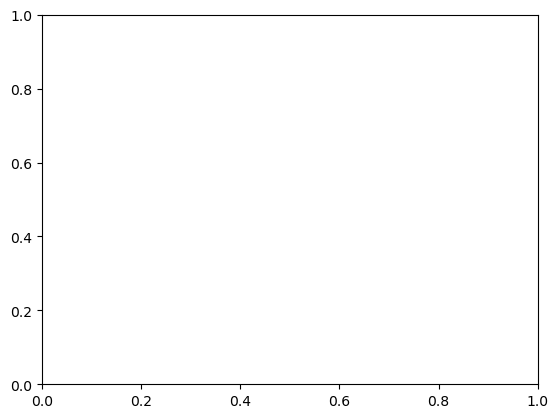

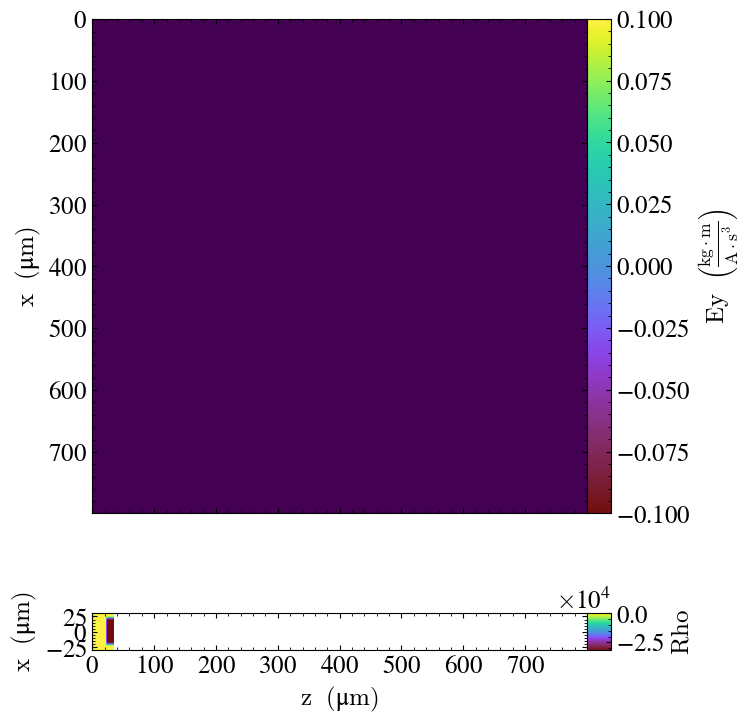

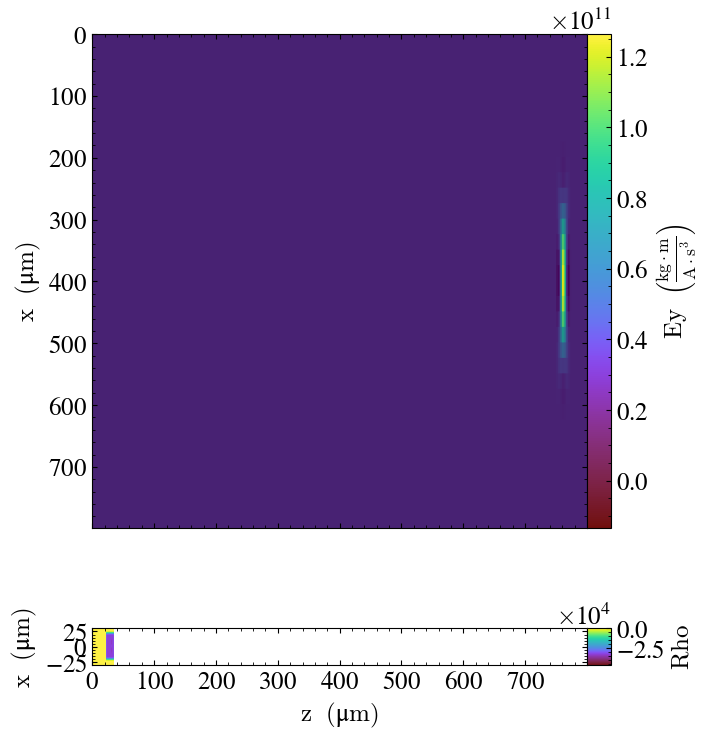

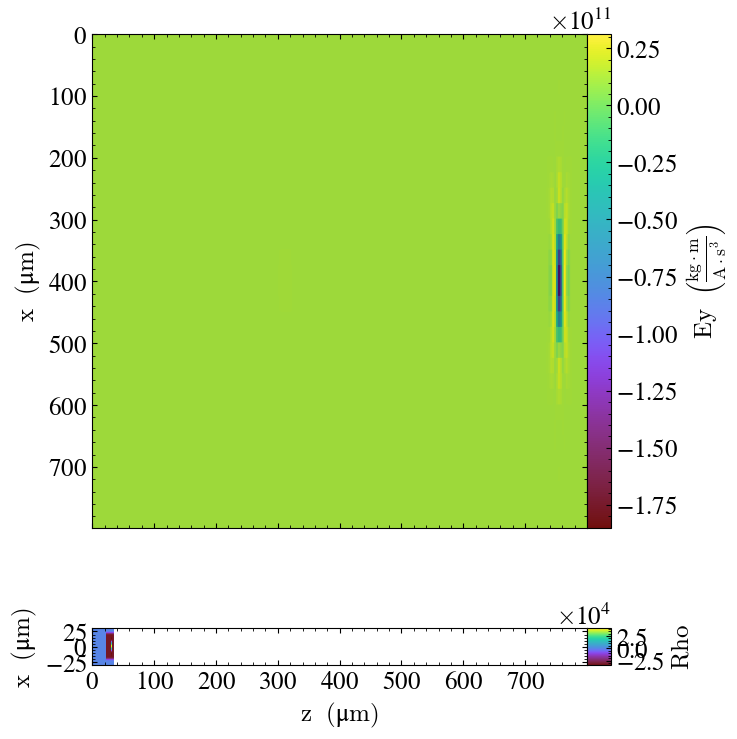

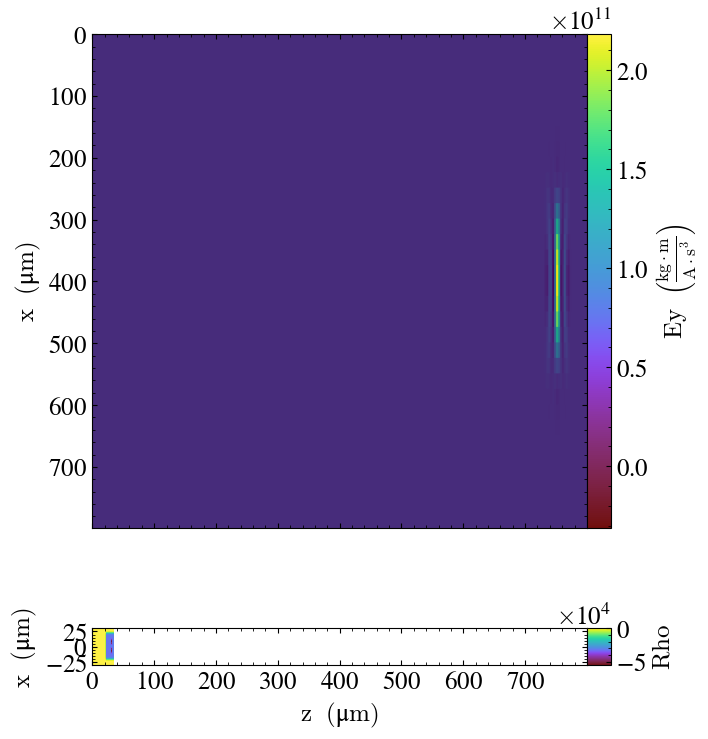

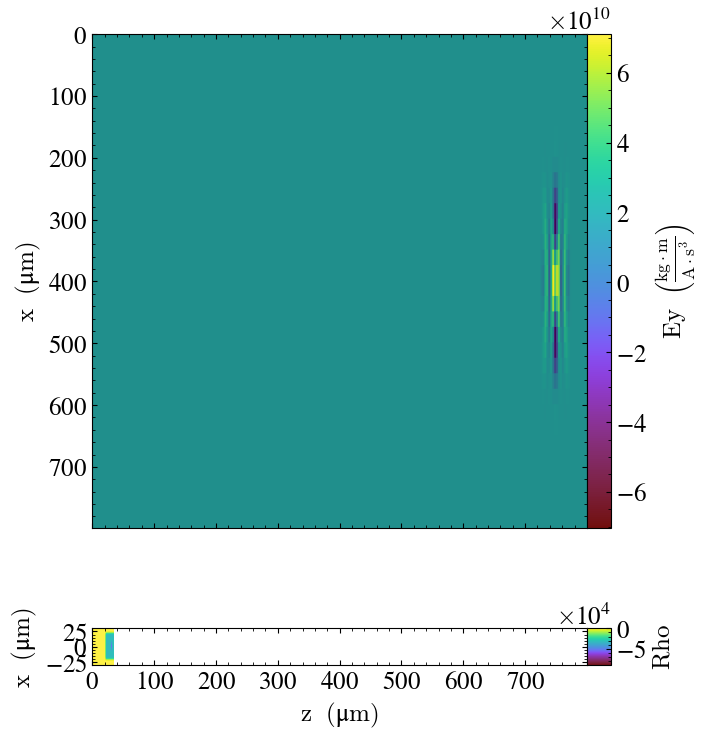

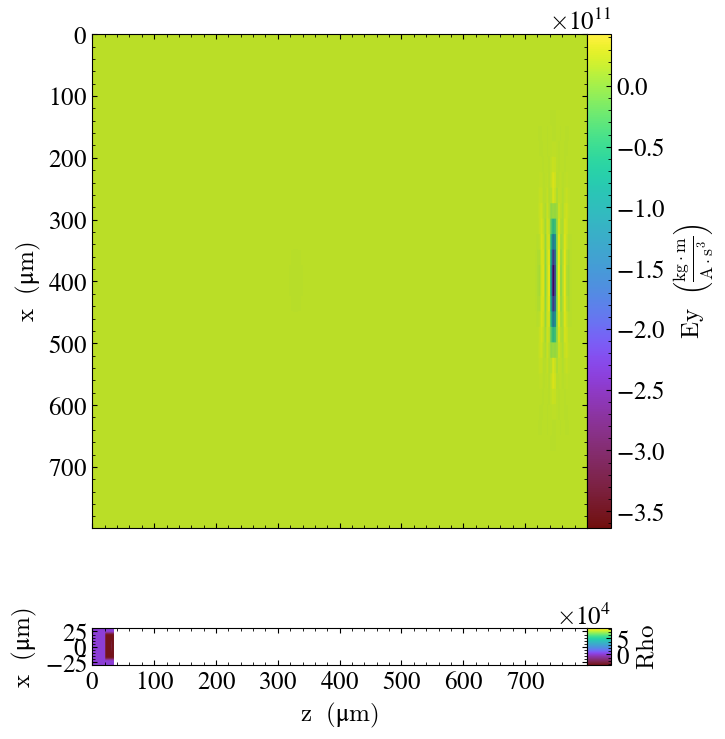

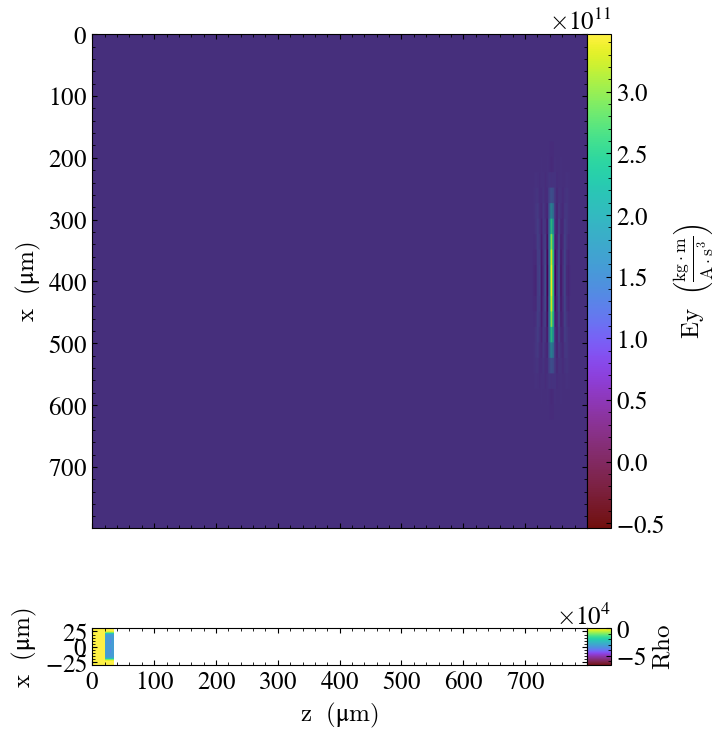

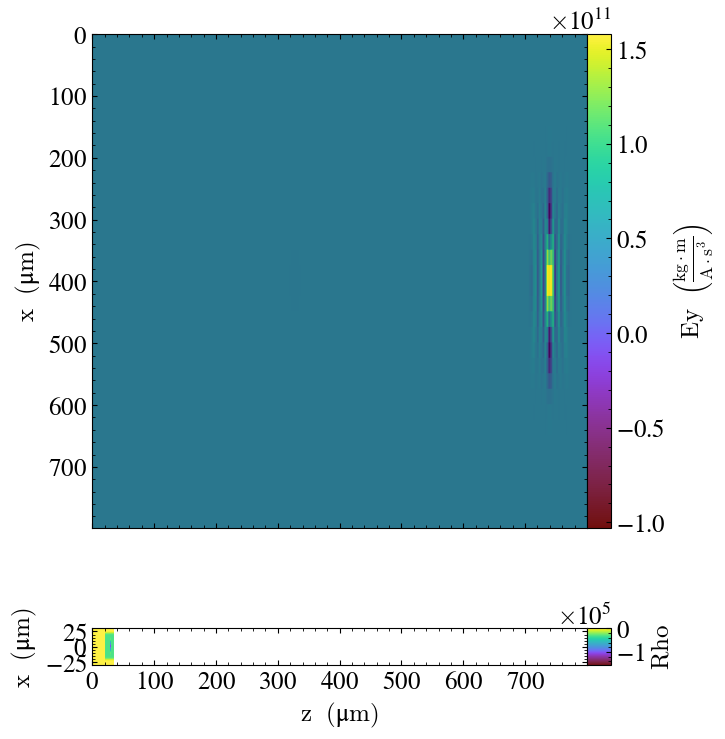

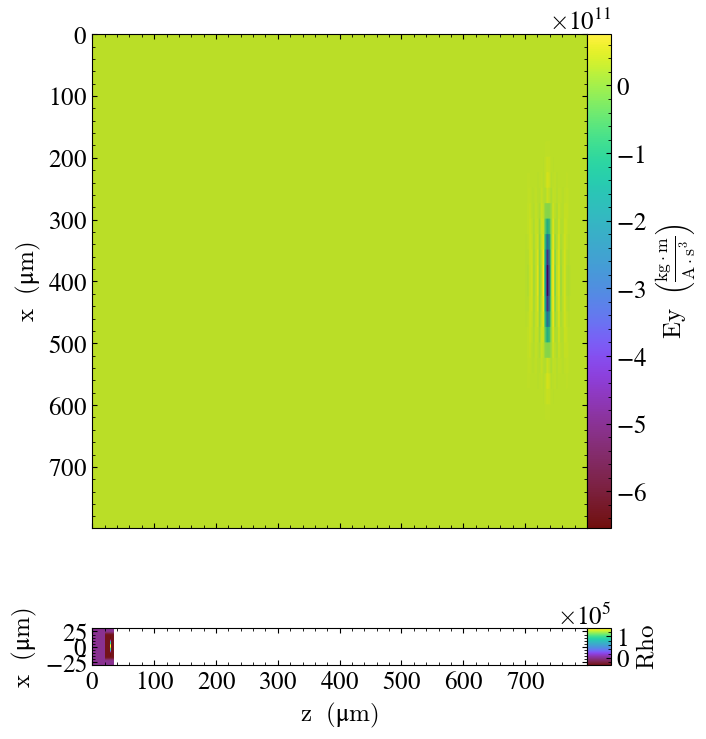

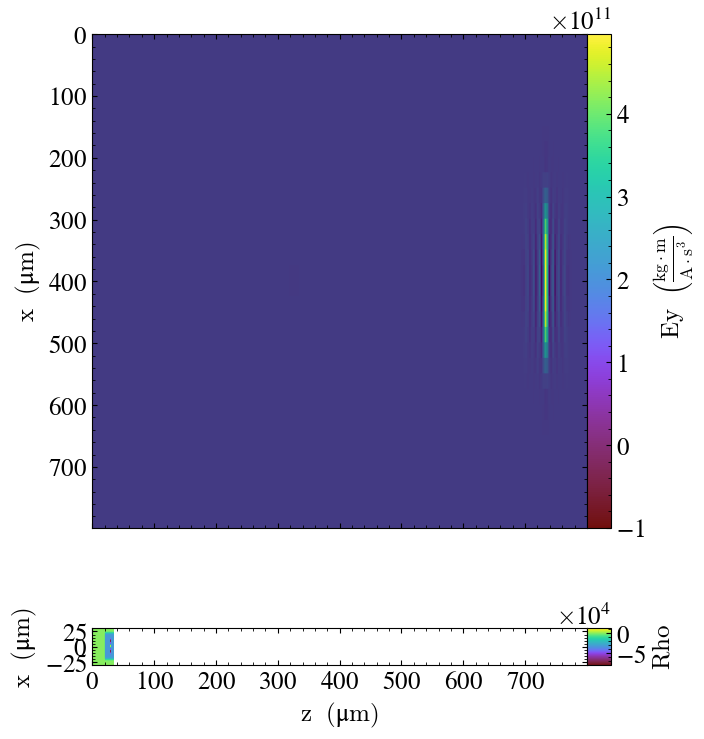

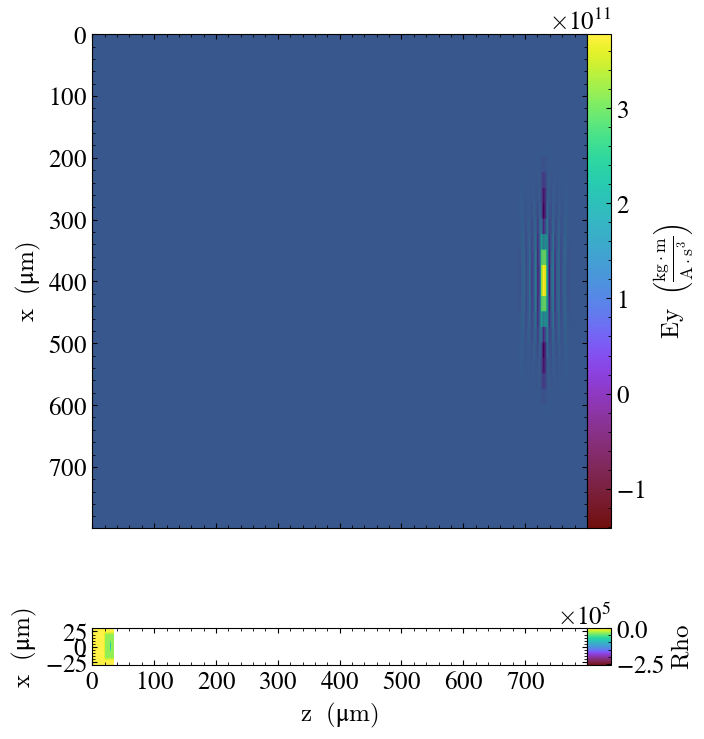

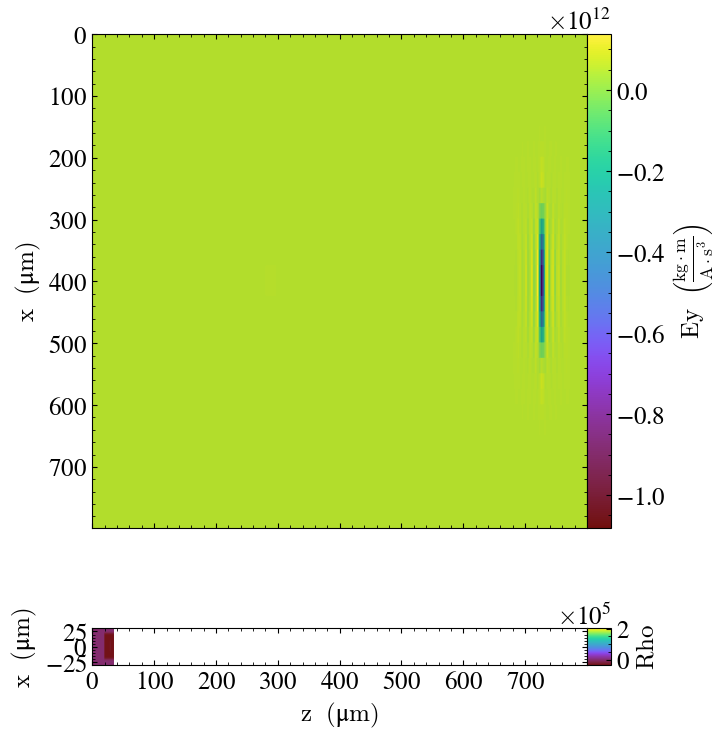

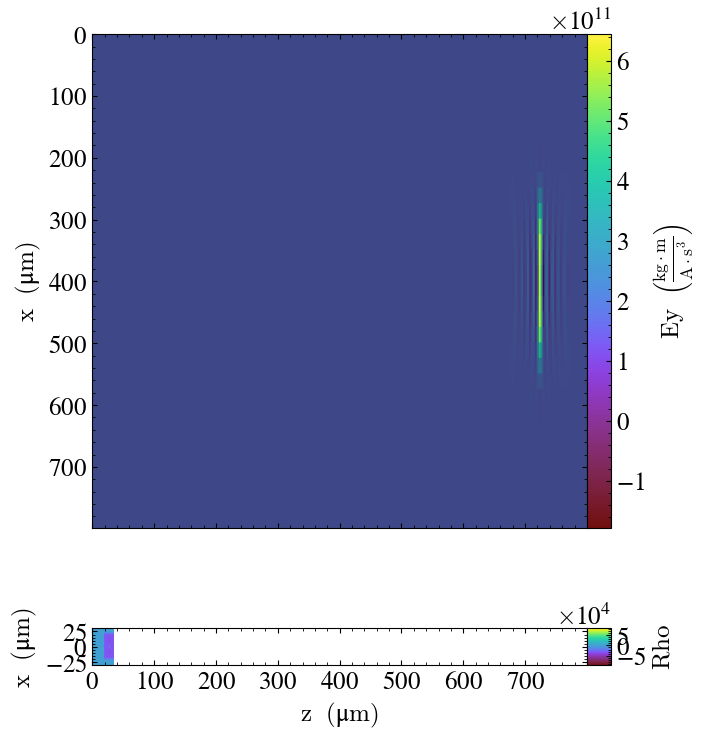

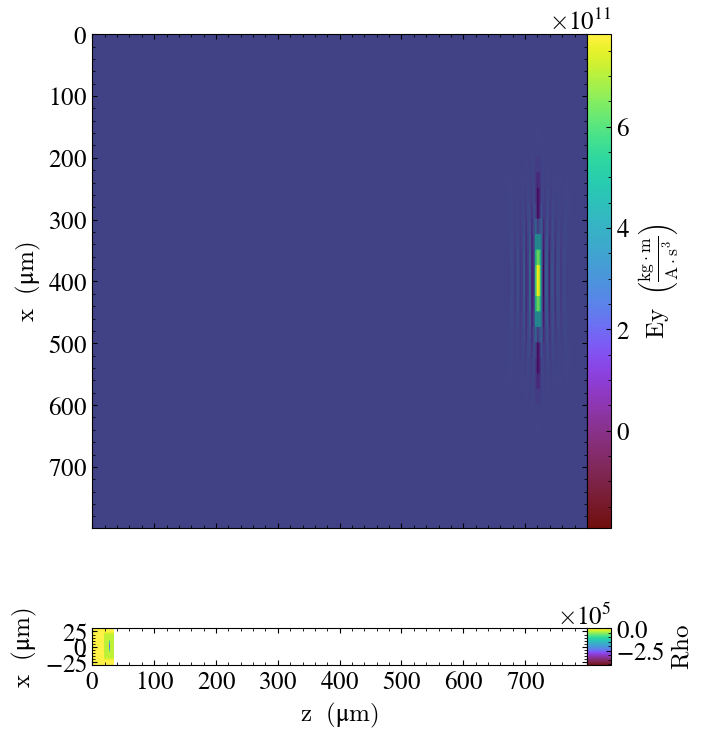

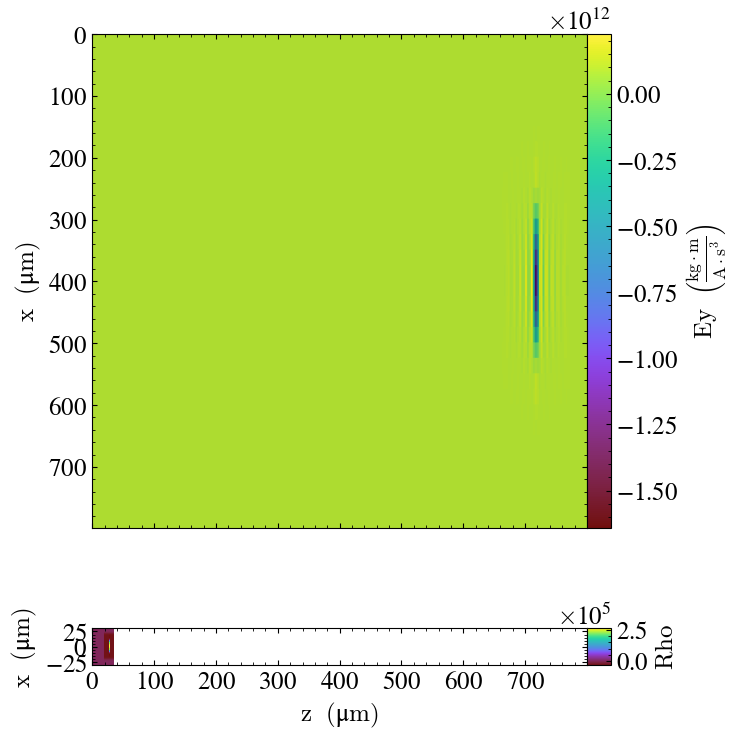

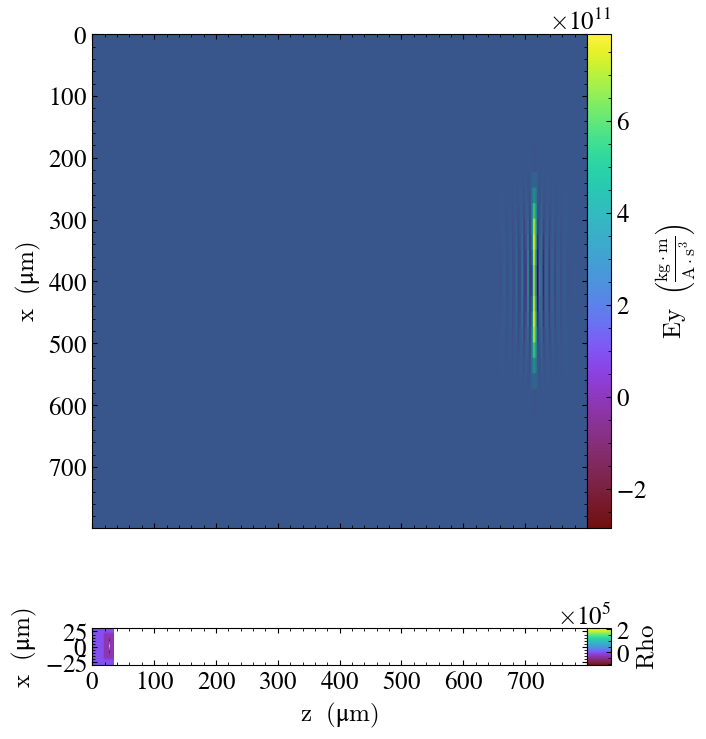

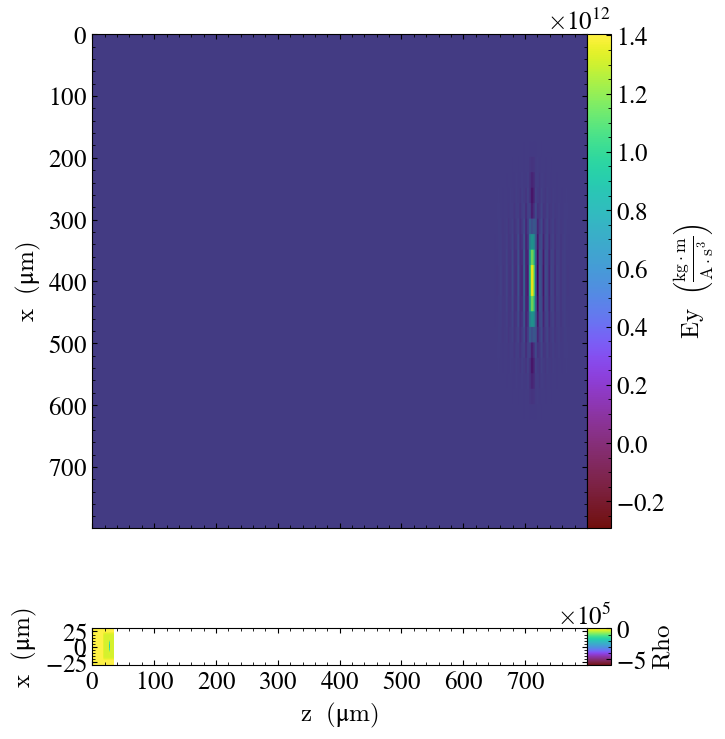

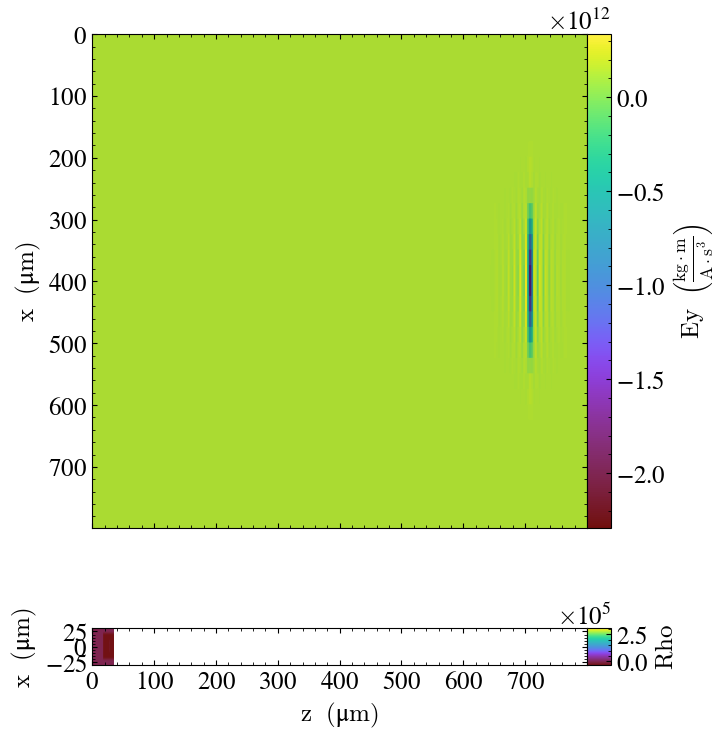

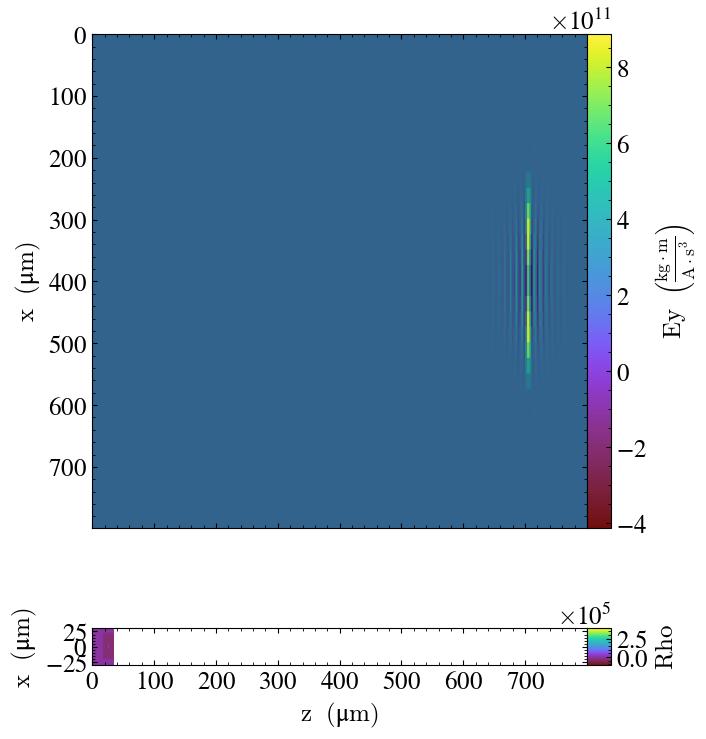

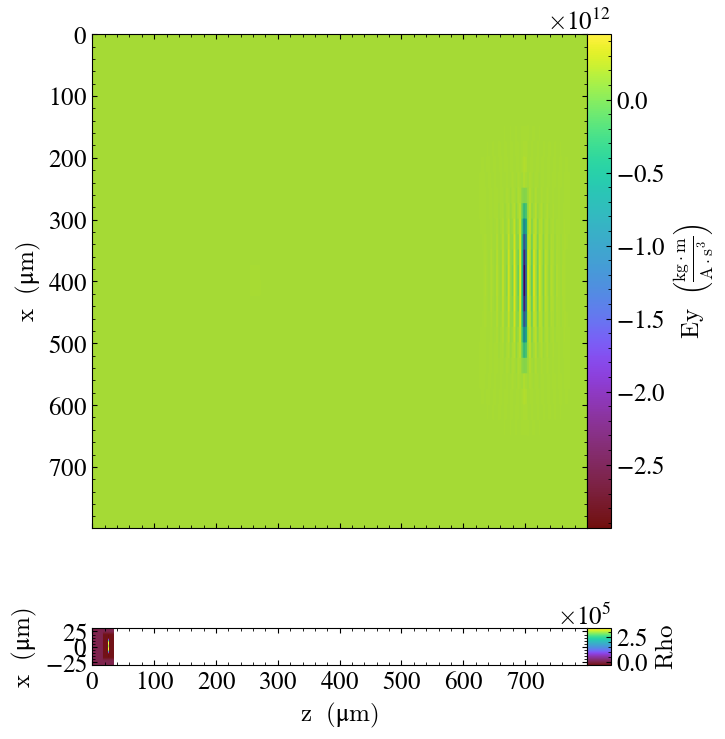

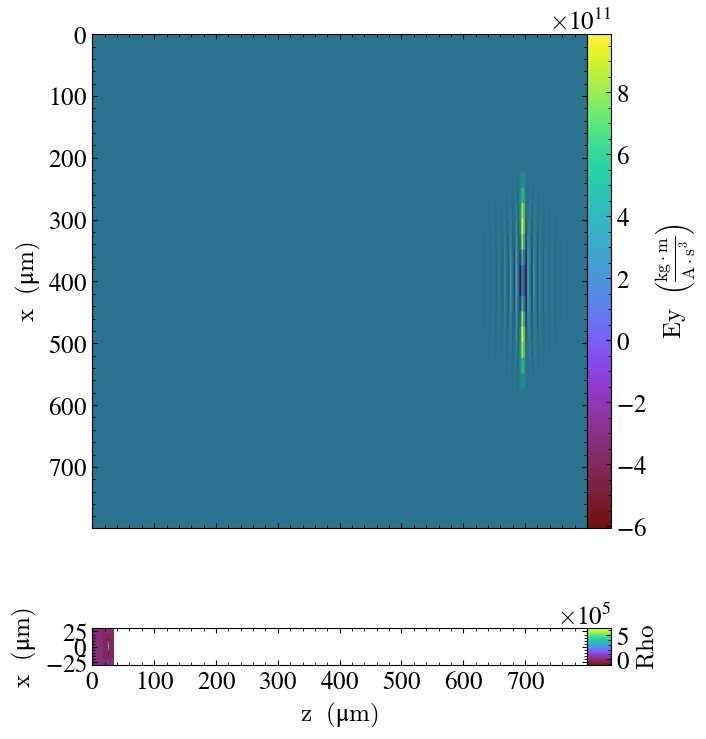

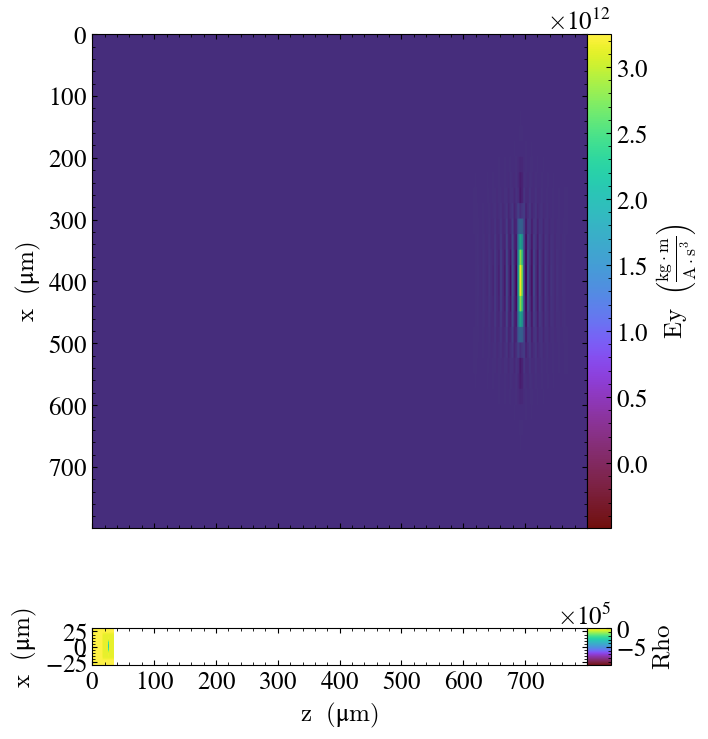

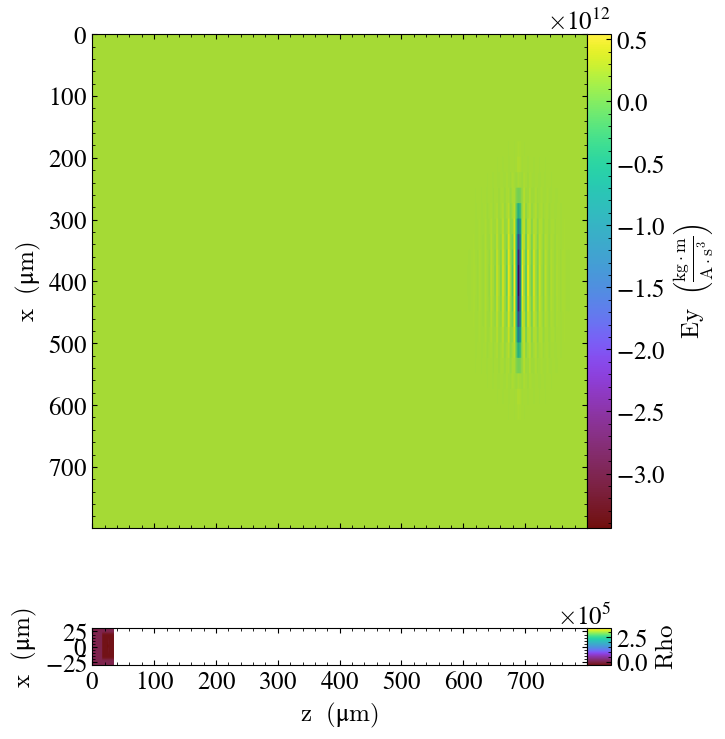

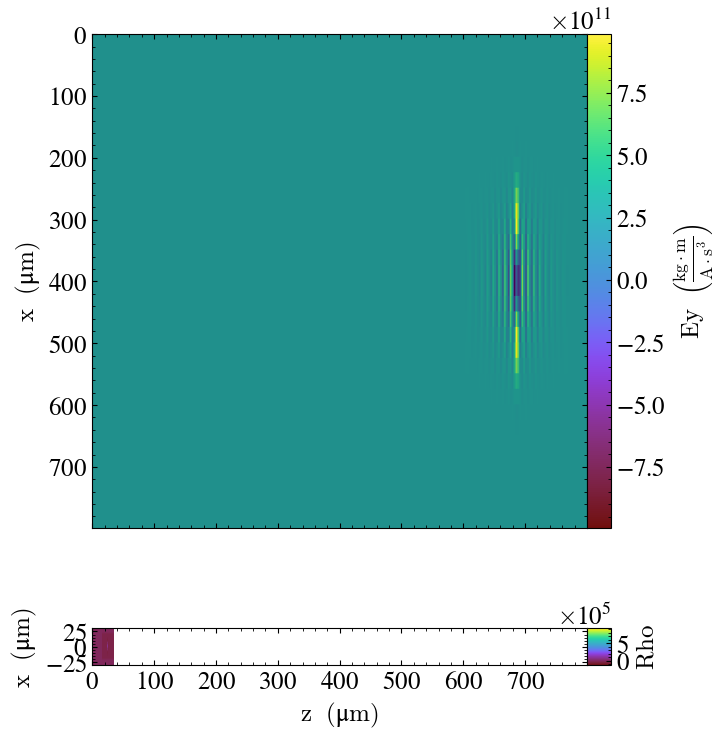

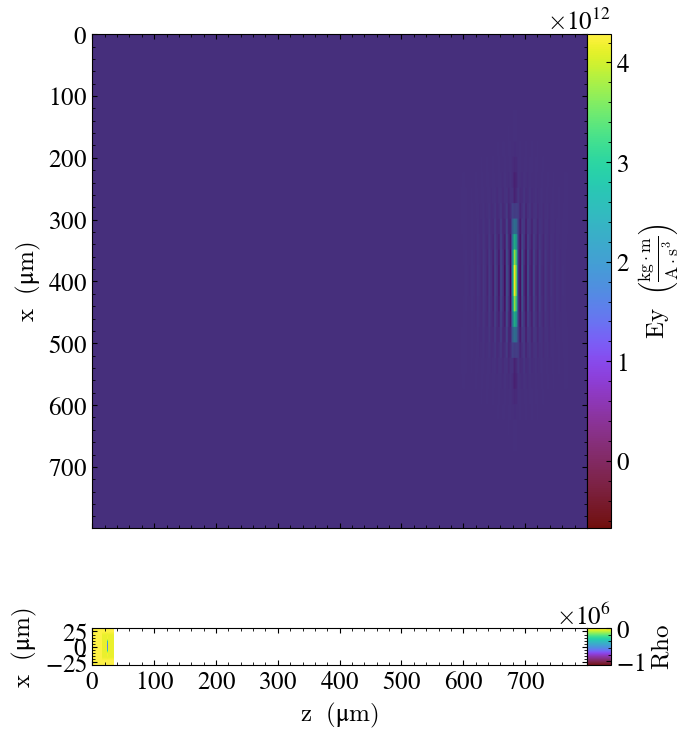

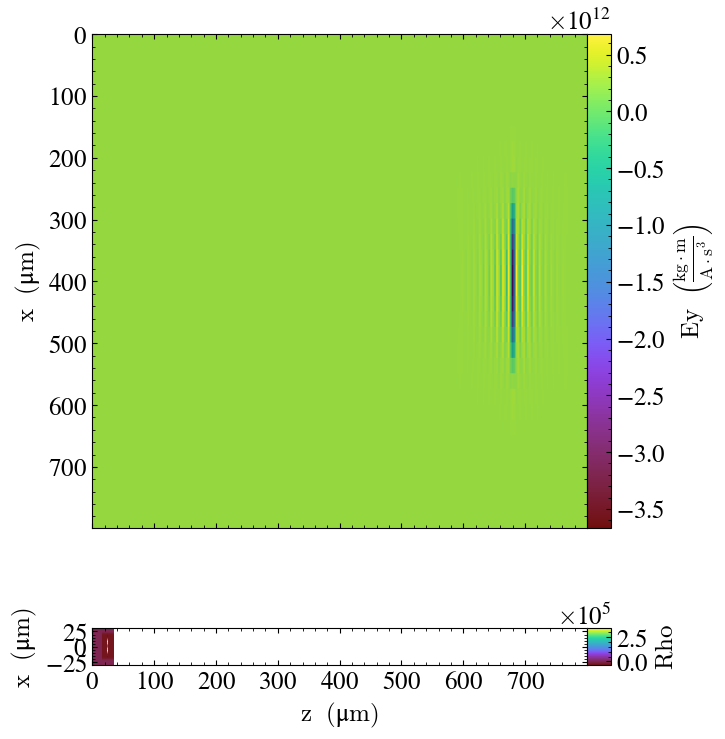

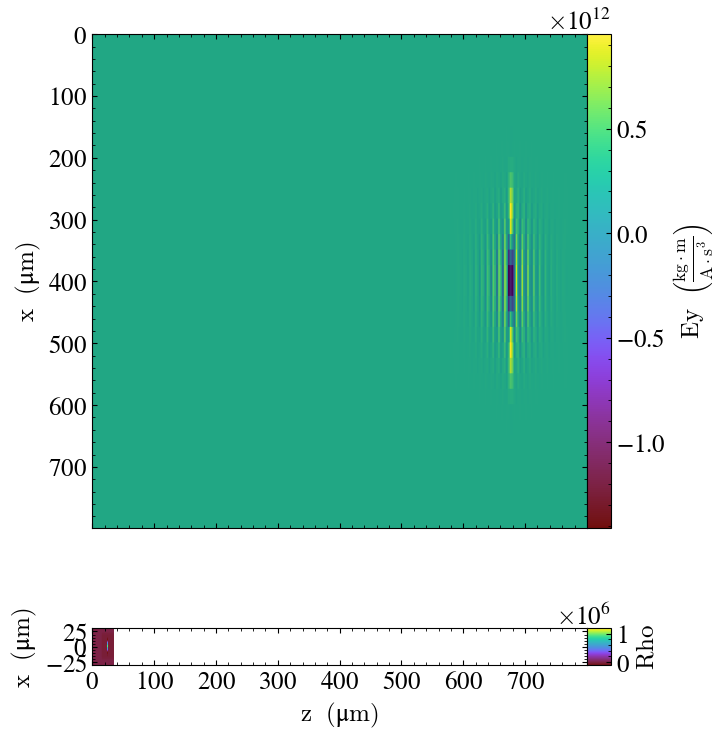

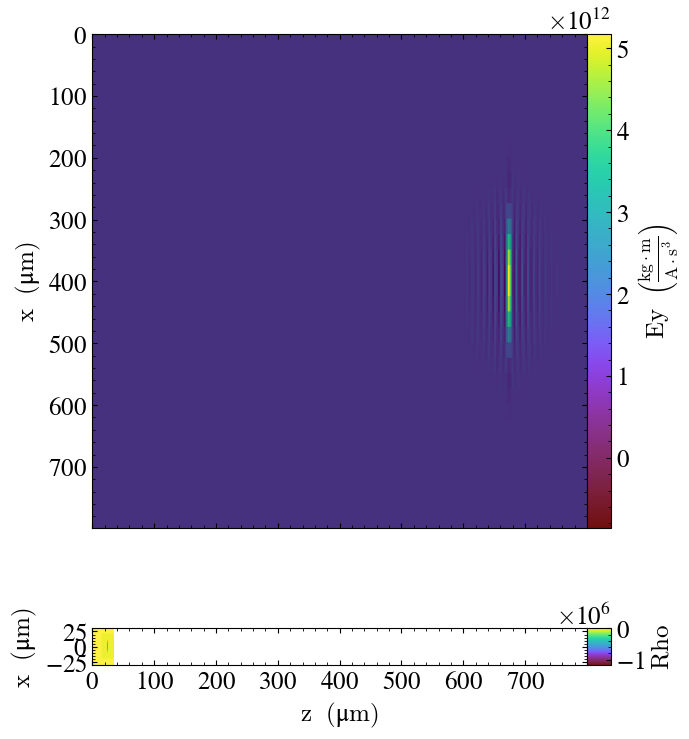

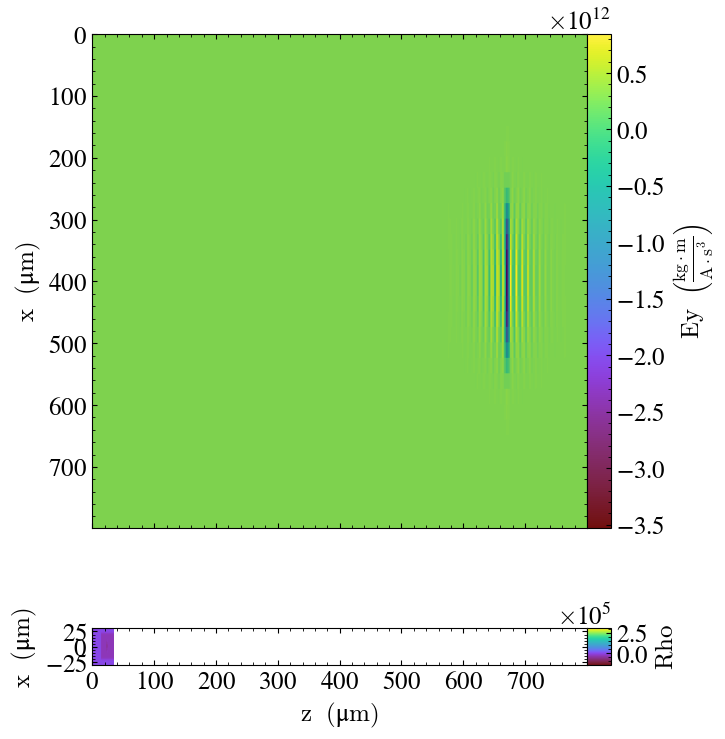

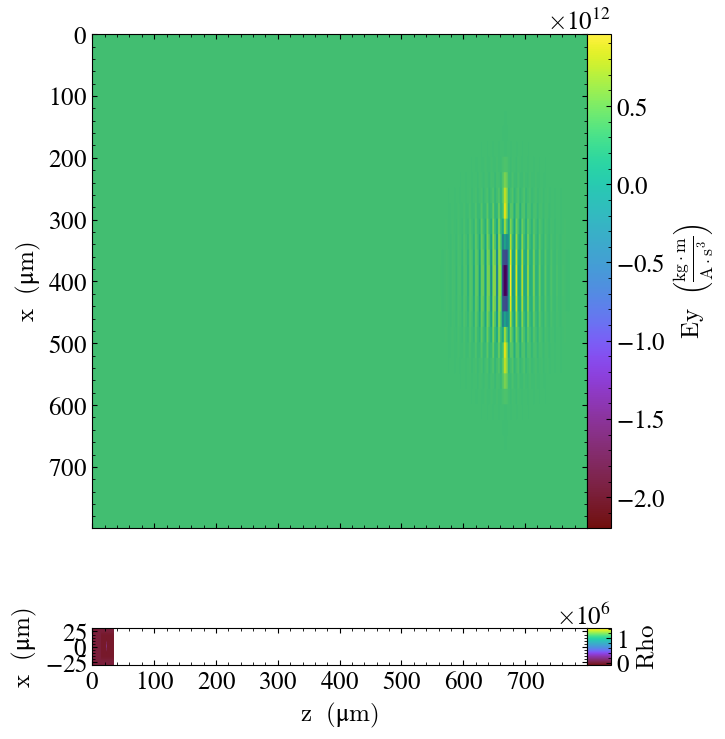

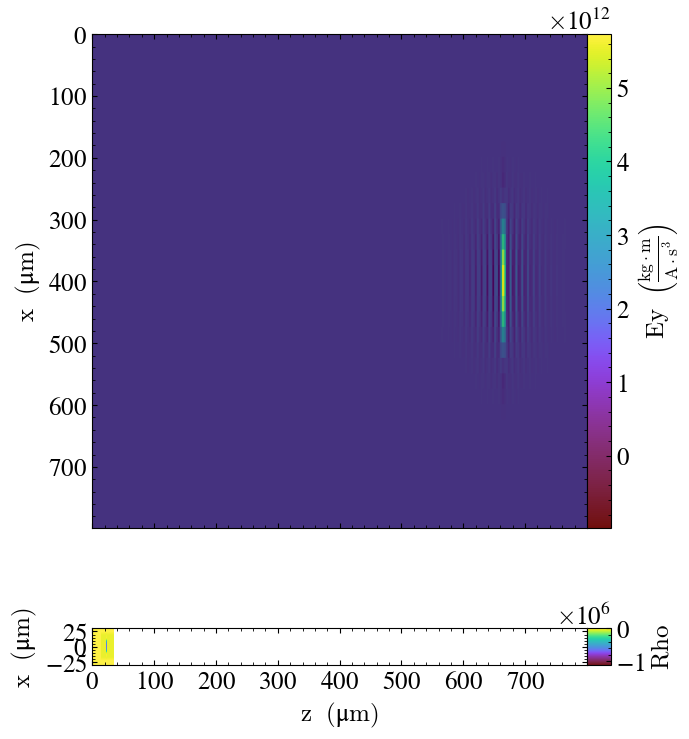

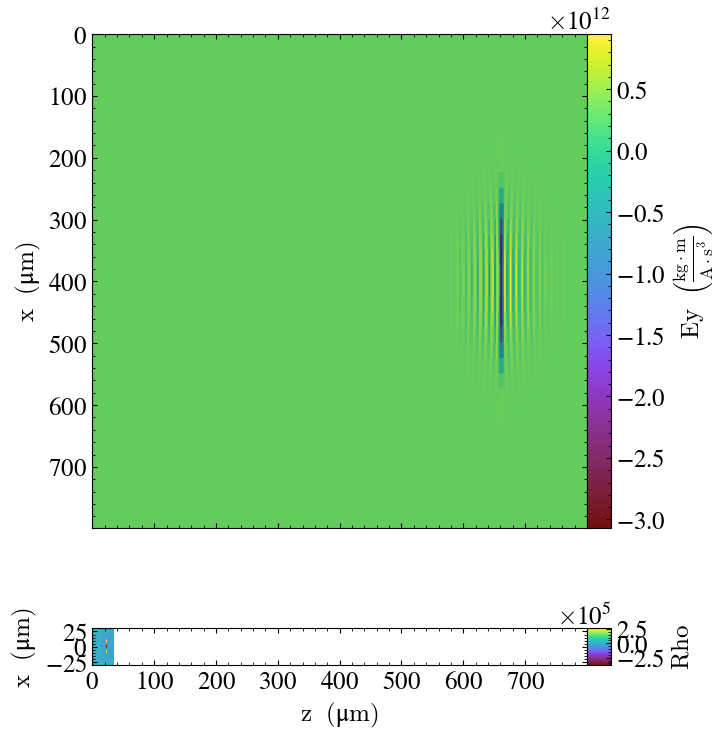

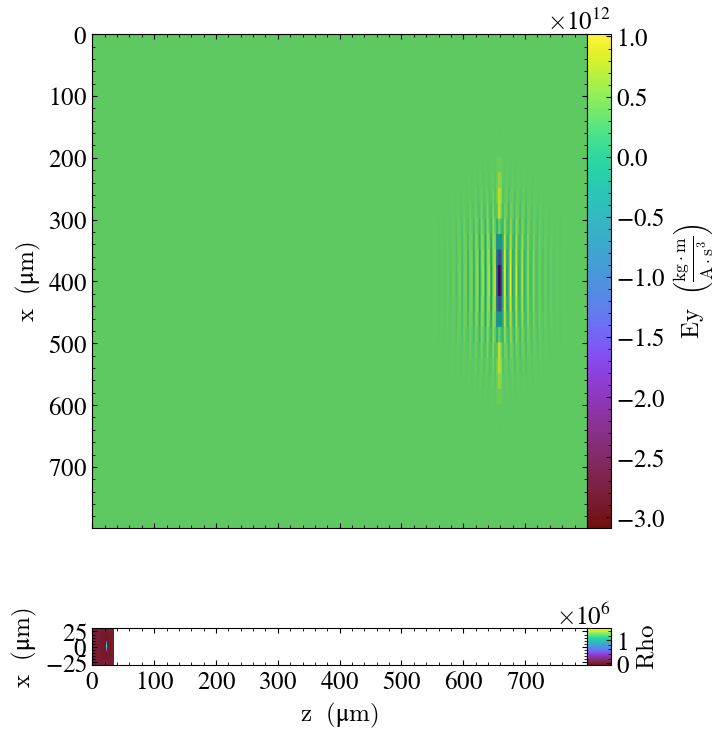

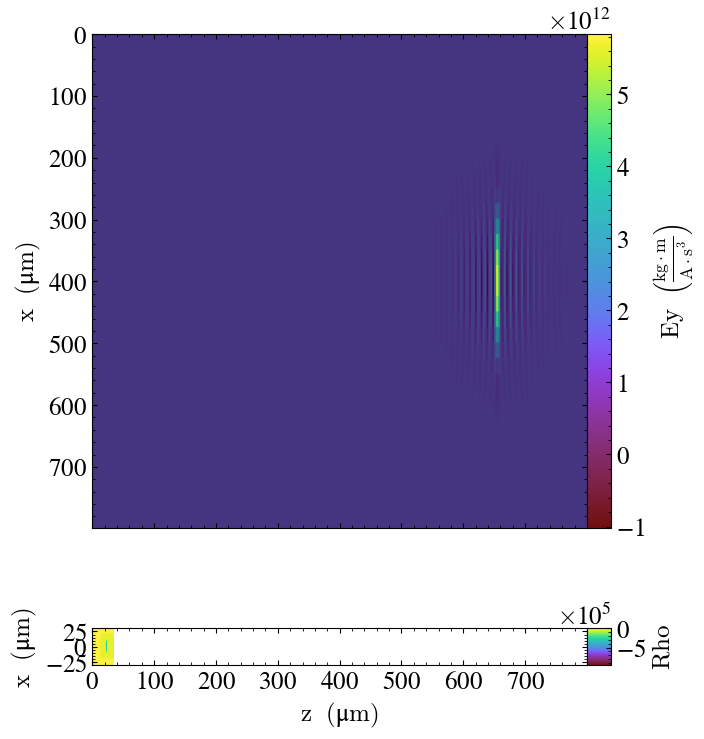

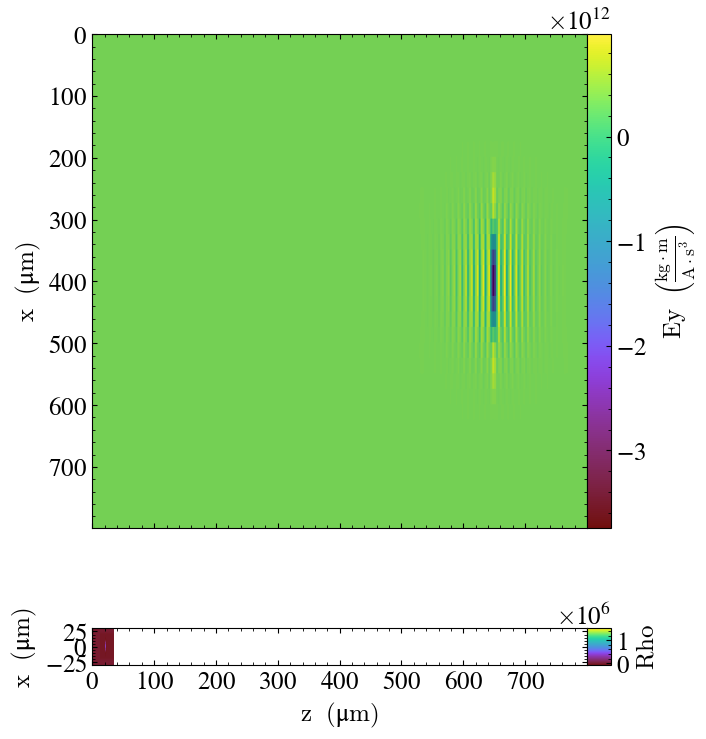

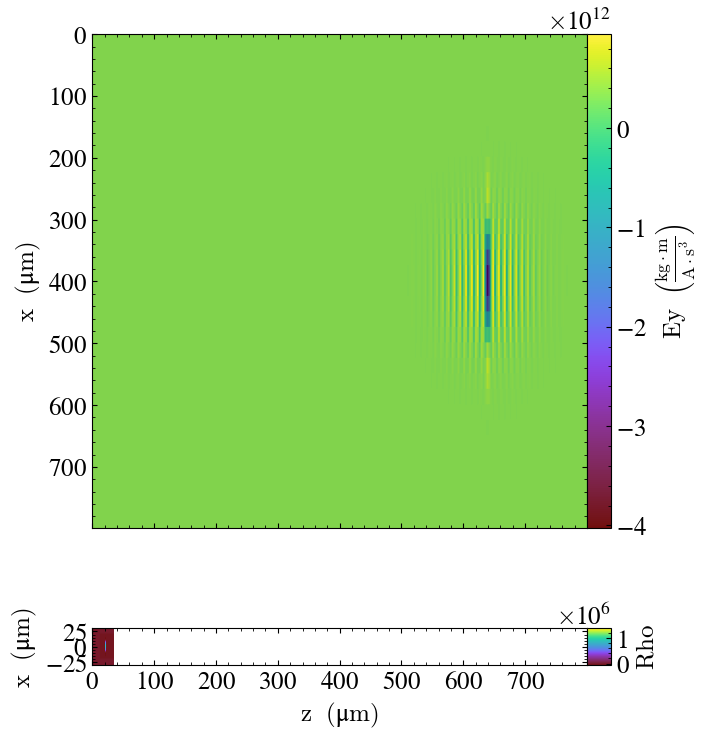

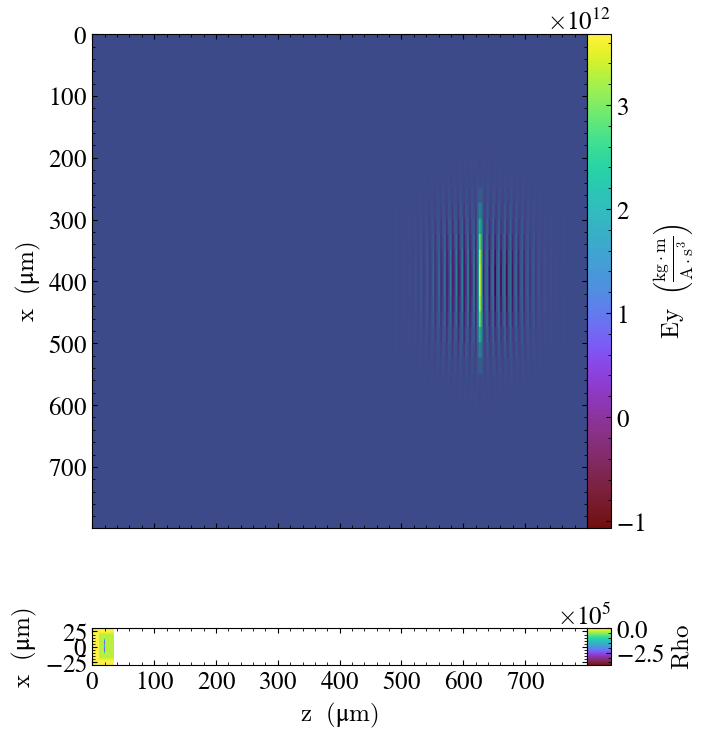

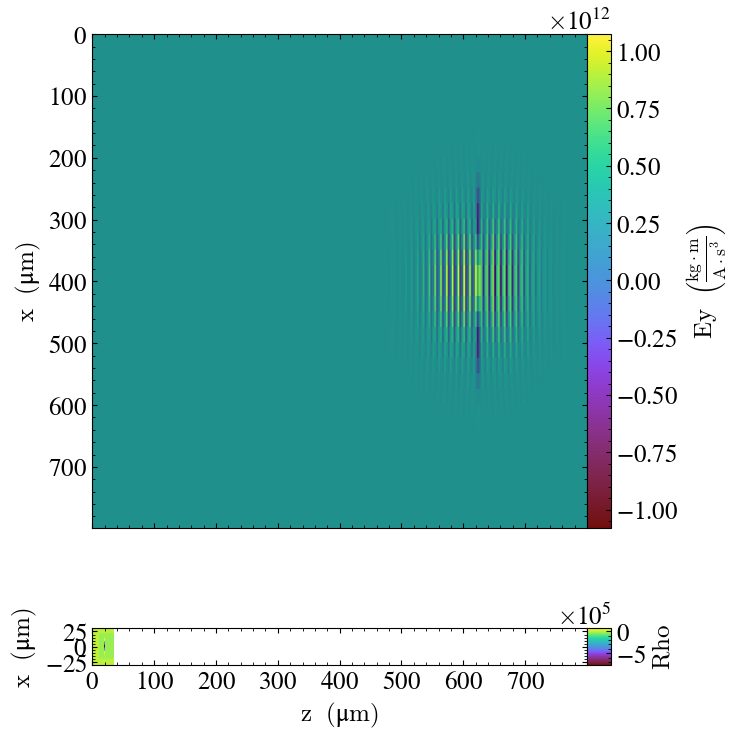

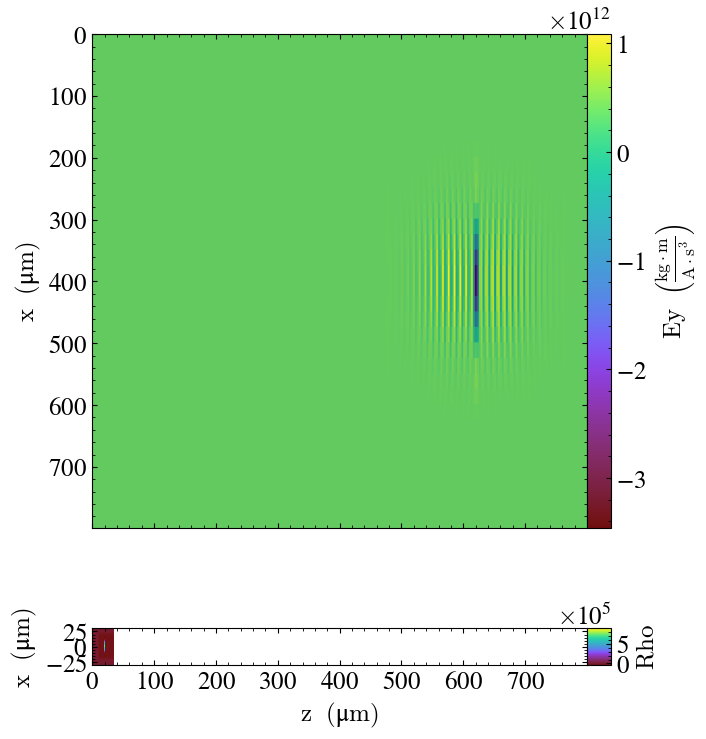

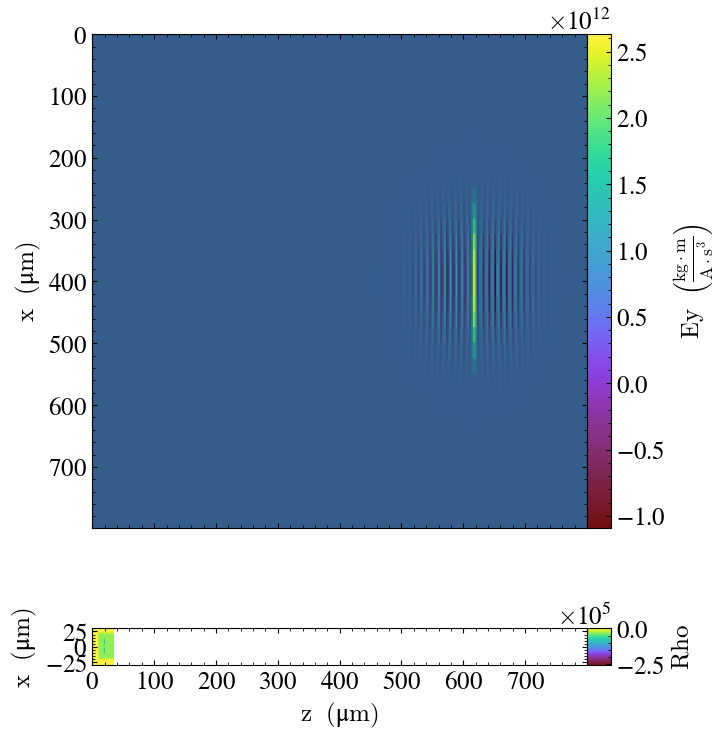

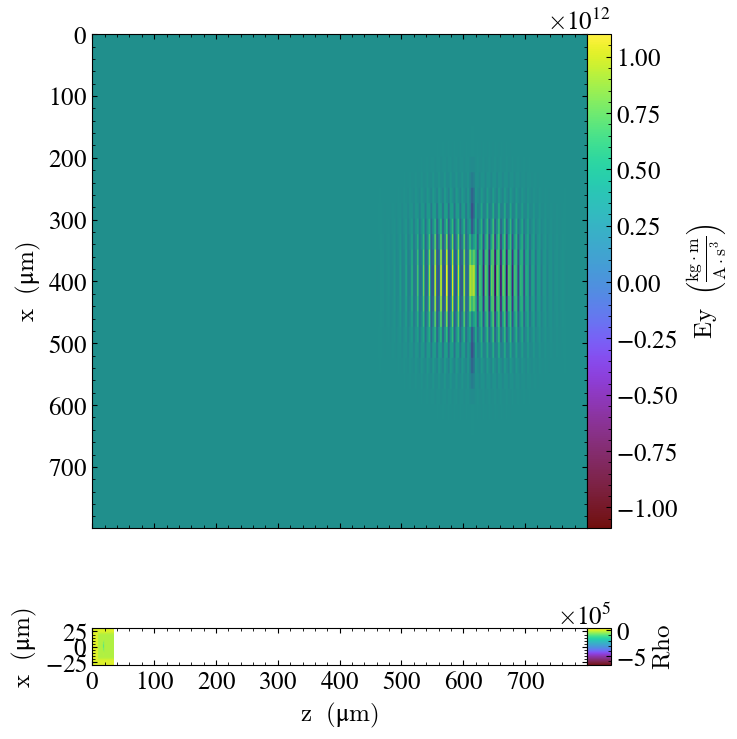

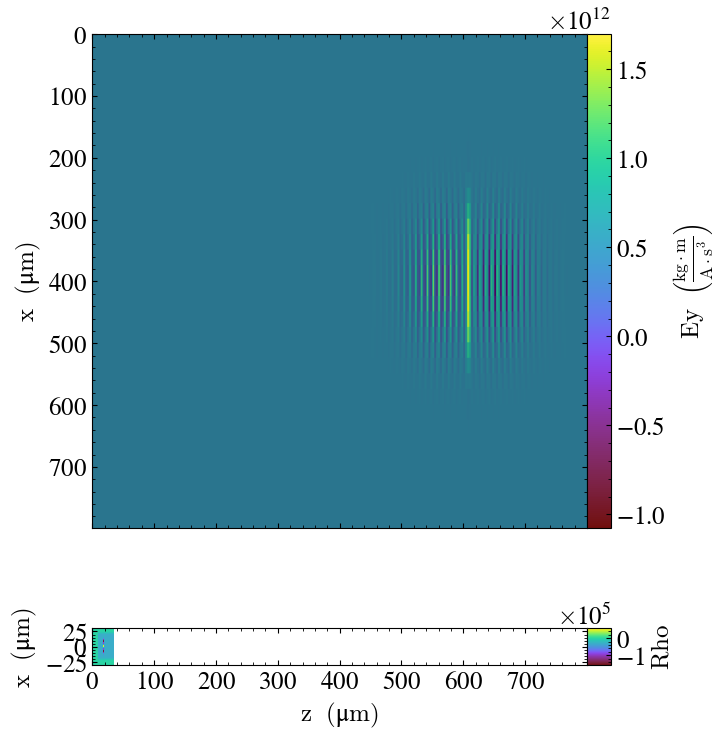

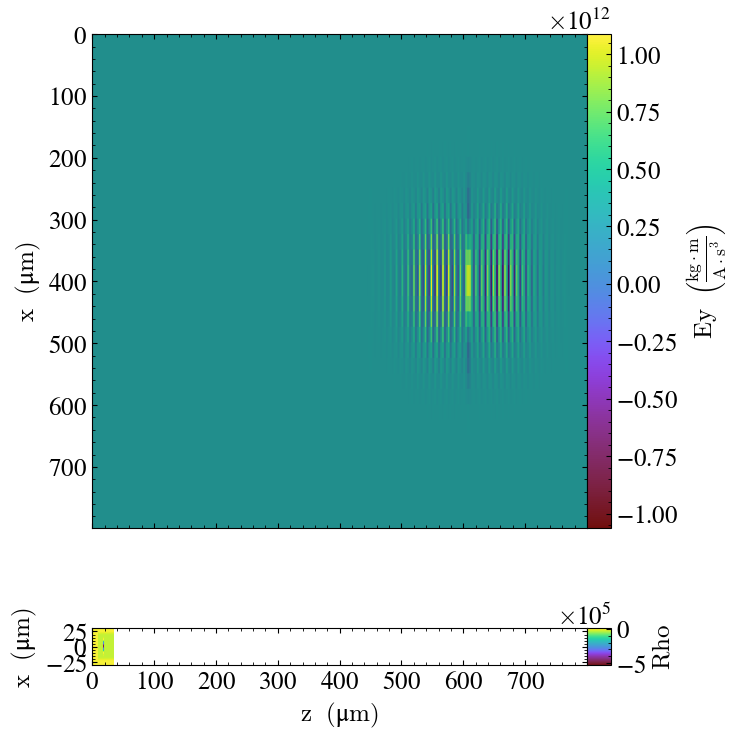

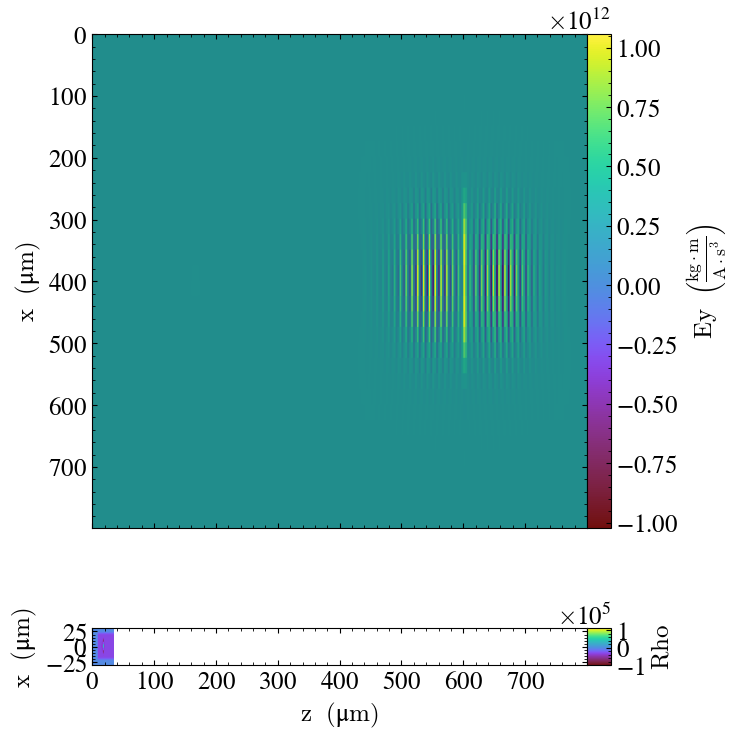

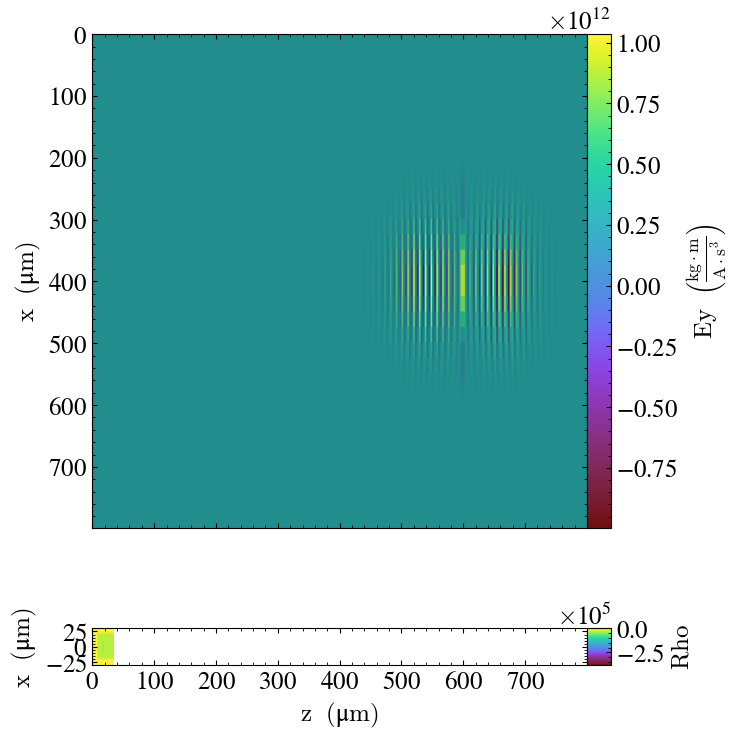

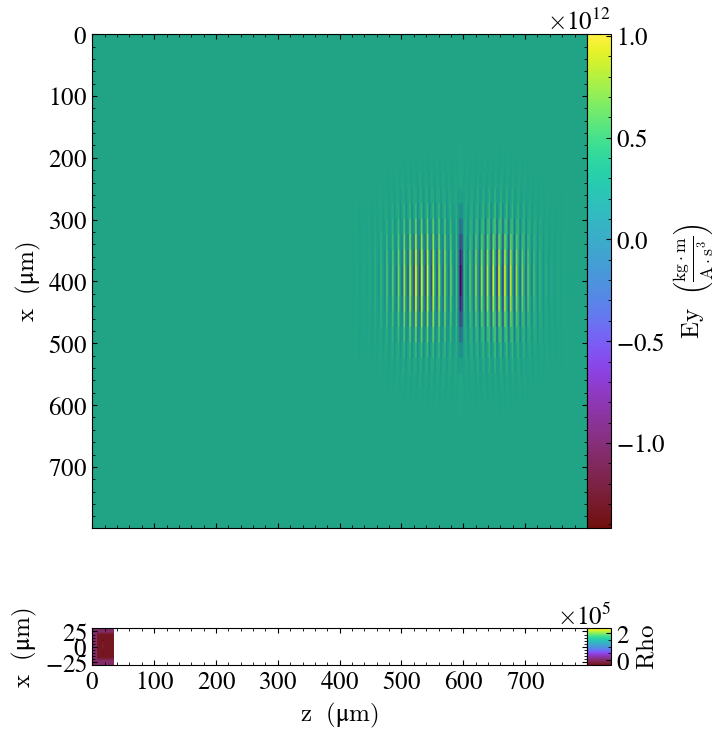

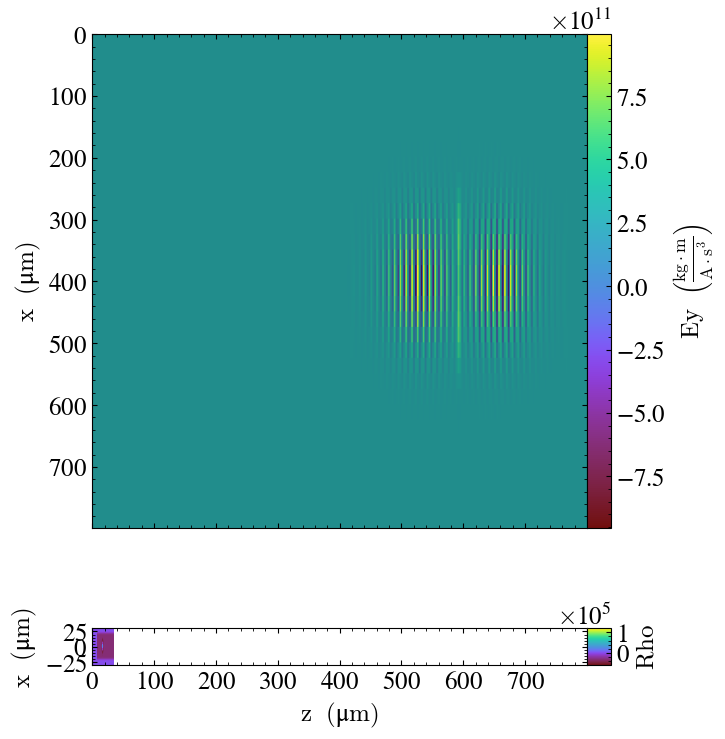

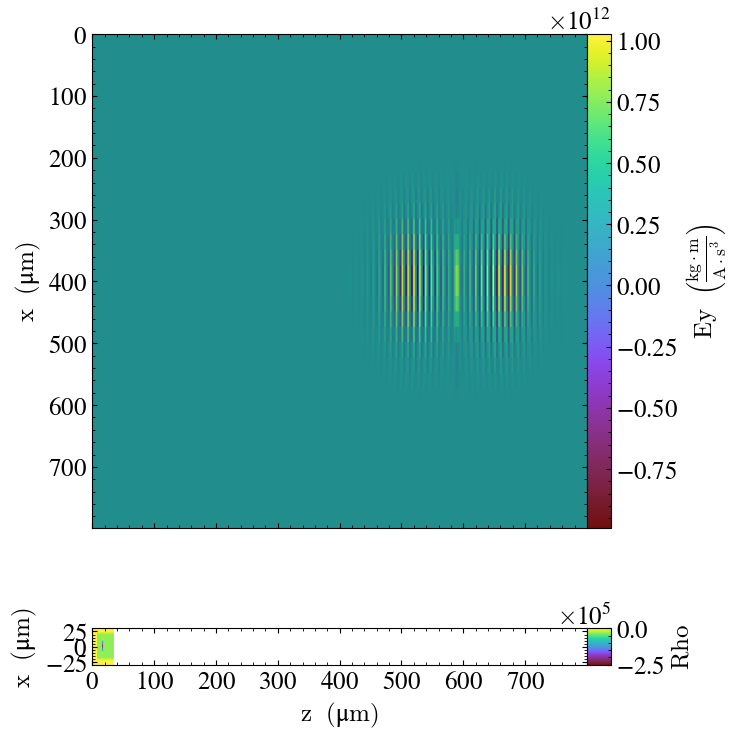

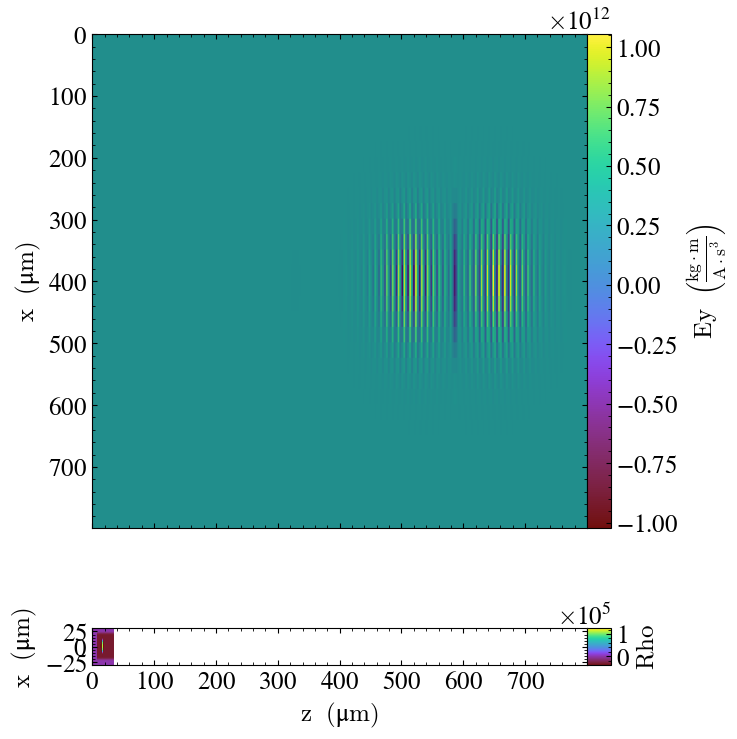

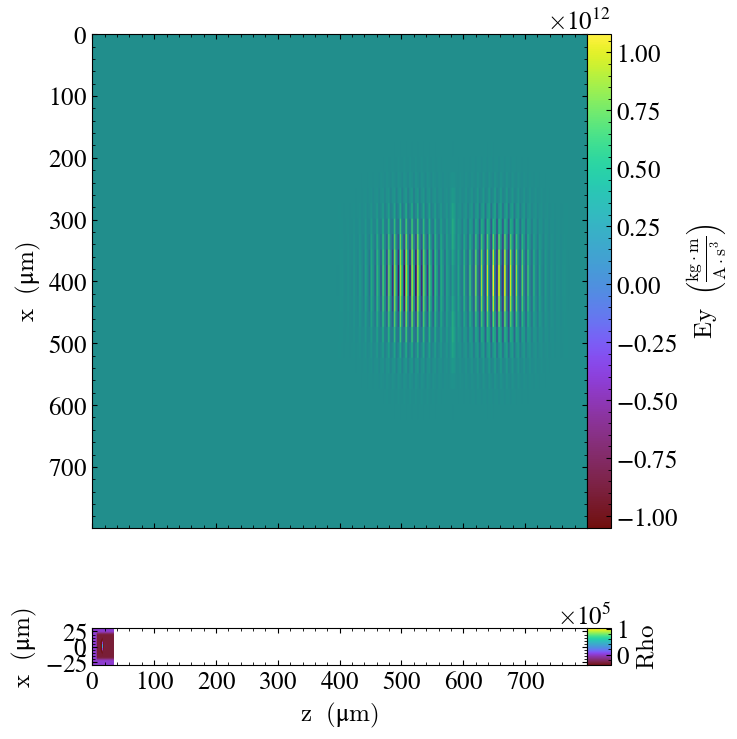

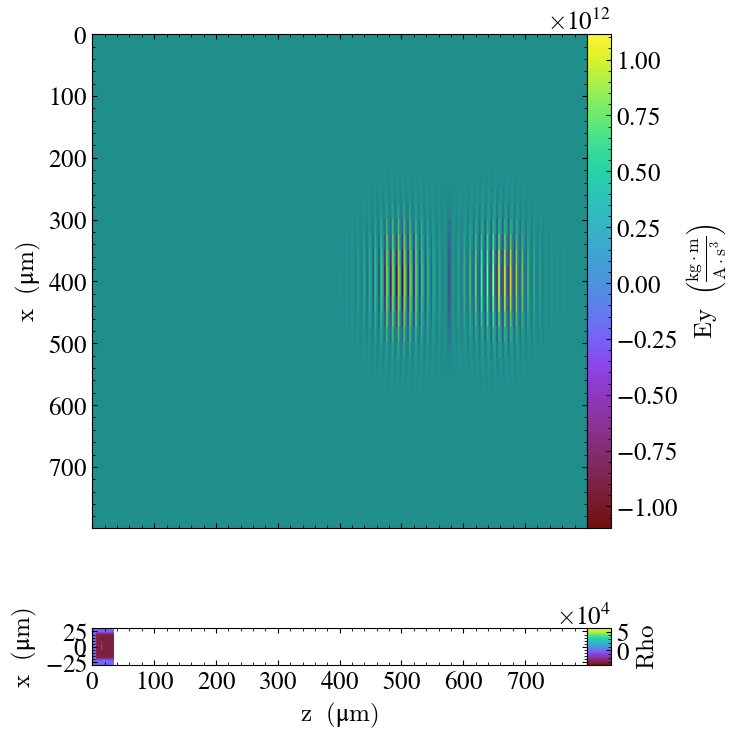

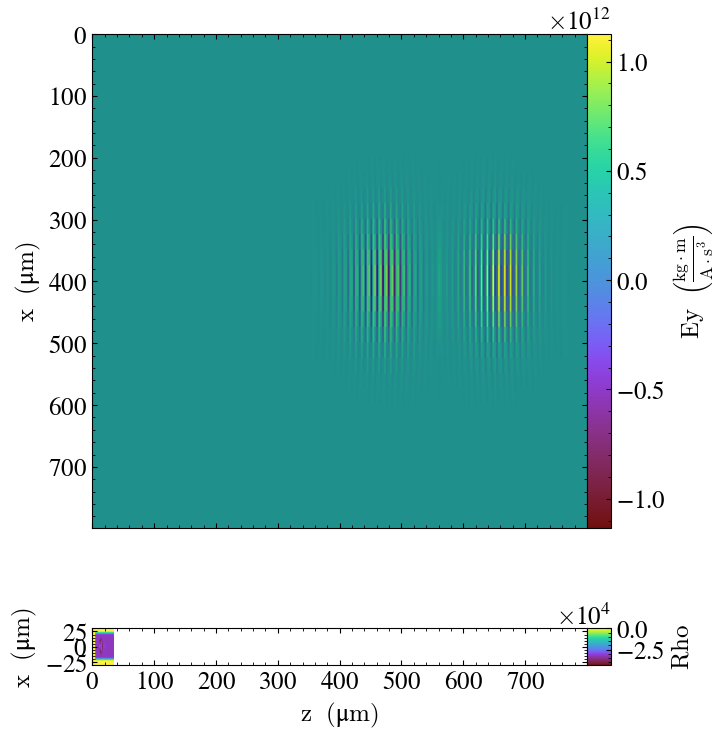

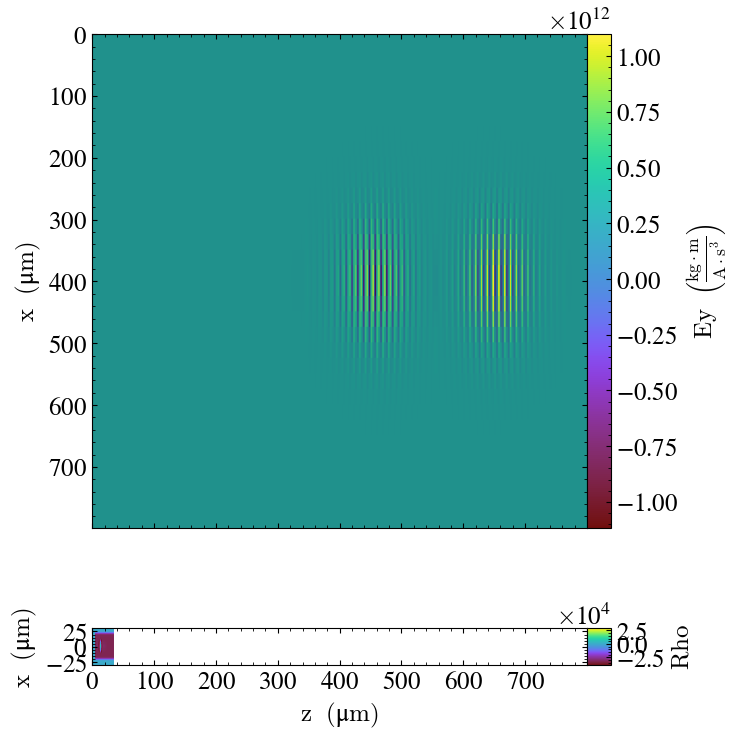

In [43]:
#!/usr/bin/env python3

# Copyright 2023 The WarpX Community
#
# This file is part of WarpX.
#
# Authors: Axel Huebl
# License: BSD-3-Clause-LBNL
#
# This is a script plots the wakefield of an LWFA simulation.

import sys
import os 
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
import yt

fig, ax = plt.subplots()  # plt.subplots() creates a new figure and ax is a variable set to it

yt.funcs.mylog.setLevel(50)

# fig, ax = plt.subplots()  # plt.subplots() creates a new figure and ax is a variable set to it


def plot_lwfa(file):
    
    # this will be the name of the plot file
    fn = file  # give file name to variable 'fn' stands for 'file name'

    # Read the file
    ds = yt.load(fn)  # load the above file into variable ds

    # plot the laser field and absolute density
    fields = ["Ey", "rho"]  # a list of fields representing physical quantities. Here it is electric field and density
    normal = "y"  # this is the axis that is perpendicular to the 2D plane
    sl = yt.SlicePlot(ds, normal=normal, fields=fields)  # make this thing 2D
    for field in fields:  # go through the list of physical quantities
        sl.set_log(field, False)  # don't do any logarithmic scaling

    sl.set_figure_size((4, 8))  # sets the dimensions of the figure height of 4in width of 8in
    fig = sl.export_to_mpl_figure(nrows_ncols=(2, 1))  # converts sl SlicePlot object into a matplotlib figure. A matplotlib fig is like a canvas to display stuff on
    
    #fig.tight_layout()
    
    ax = fig.axes[0]  # accessing the first subplot from the grid of subplots (top left?)
    
    # Get the image data from the subplot
    image_data = ax.images[0].get_array()  # display data as an image, i.e., on a 2D regular raster.
    
    print(f"{file} LOADED...")
    
    ax.set_aspect(aspect='equal')
    
    matplotlib.pyplot.close()
    
    return [ax.imshow(image_data, aspect='auto')]  # PUTTING THE IMAGES IN A LIST IS THE PROBLEM!!!! Maybe it has to do with the size of the sim drawings????????????????


frame_number = 70
ims = []  # a list of lists in which each index is a frame of the animation
for i in range(frame_number):
    if i < 10:
        ims.append(plot_lwfa(f"Python_LaserAcceleration_plt00000{i}"))
    elif i >= 10 and i < 100:
        ims.append(plot_lwfa(f"Python_LaserAcceleration_plt0000{i}"))
    elif i >= 100 and i < 1000:
        ims.append(plot_lwfa(f"Python_LaserAcceleration_plt000{i}"))
    elif i >= 1000 and i < 10000:
        ims.append(plot_lwfa(f"Python_LaserAcceleration_plt00{i}"))
    elif i >= 10000 and i < 100000:
        ims.append(plot_lwfa(f"Python_LaserAcceleration_plt0{i}"))
        
print("Frame gathering complete!")

# iterates through the list of lists to create an animation object
animate = animation.ArtistAnimation(fig, ims, interval = 250, blit = False, repeat_delay = 0)

    
animate.save("plasma_sim_2D.mp4")


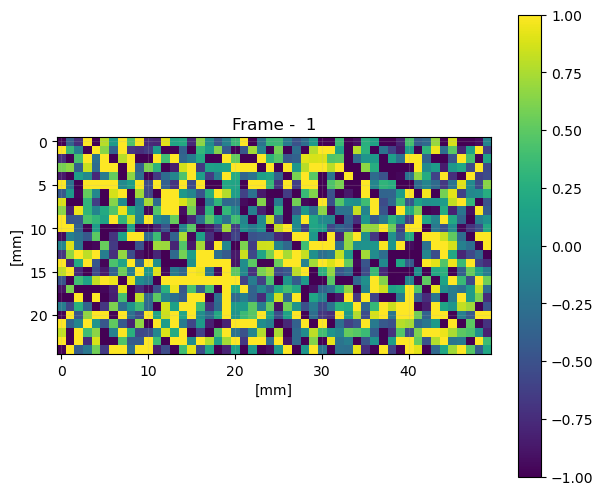

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

figsize=(7, 6)
fig = plt.figure(figsize=figsize)
plt.ion()
ax = fig.add_subplot(1, 1, 1)
ax.grid(alpha =0.2)
ax.set_xlabel("[mm]")
ax.set_ylabel("[mm]")
row_size=25
column_size=50
I = np.random.rand(row_size, column_size)
I2 = np.sqrt(I)
im = ax.imshow(I,vmin=-1, vmax=1)
	
ax.set_title("Screen distance = " + str(0) + " cm")	
ax.set_aspect('equal')
plt.colorbar(im, orientation = 'vertical')	


def animate(i):
	
	frame1=i
		
	I = np.random.randn(row_size, column_size)
	ax.set_title("Frame -  " + str(frame1+1)  )
	im.set_array(I)
	return[im]


fps = 30
ani = animation.FuncAnimation(fig, animate, frames=120, interval=250, repeat=False)
#lt.show()
ani.save('Test.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

Frame gathering complete!
FILE #1 LOADED...
FILE #1 LOADED...
FILE #2 LOADED...
FILE #3 LOADED...
FILE #4 LOADED...
FILE #5 LOADED...
FILE #6 LOADED...
FILE #7 LOADED...
FILE #8 LOADED...
FILE #9 LOADED...
FILE #10 LOADED...
FILE #11 LOADED...
FILE #12 LOADED...
FILE #13 LOADED...
FILE #14 LOADED...
FILE #15 LOADED...


IndexError: list index out of range

FILE #1 LOADED...


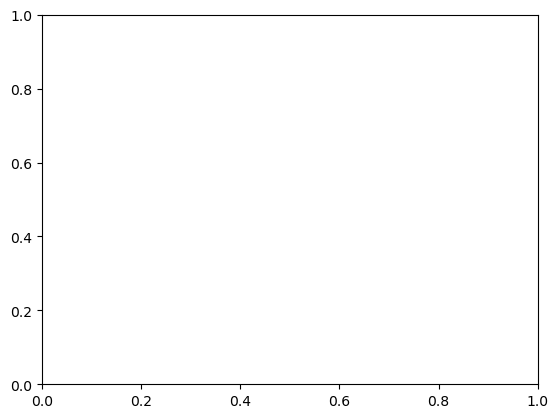

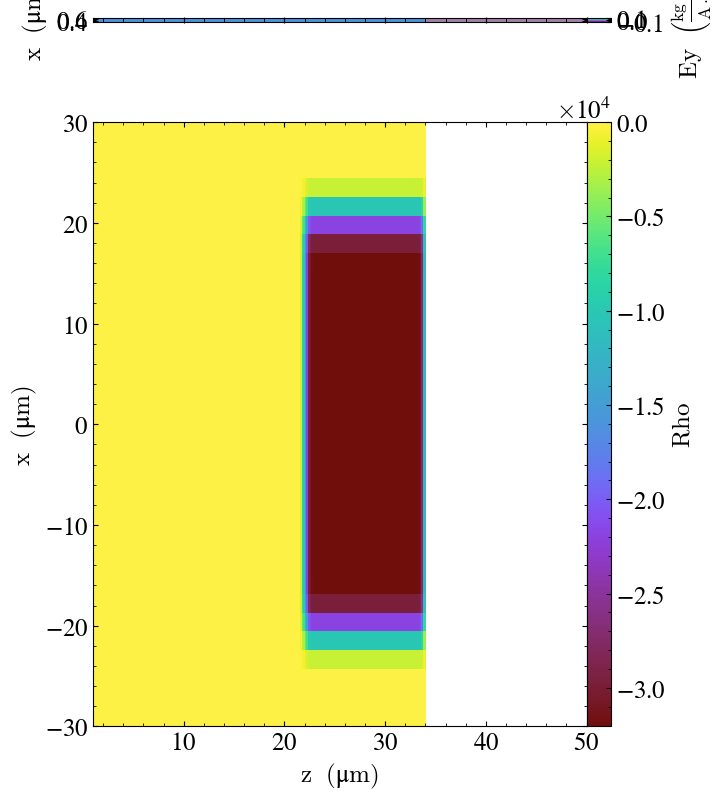

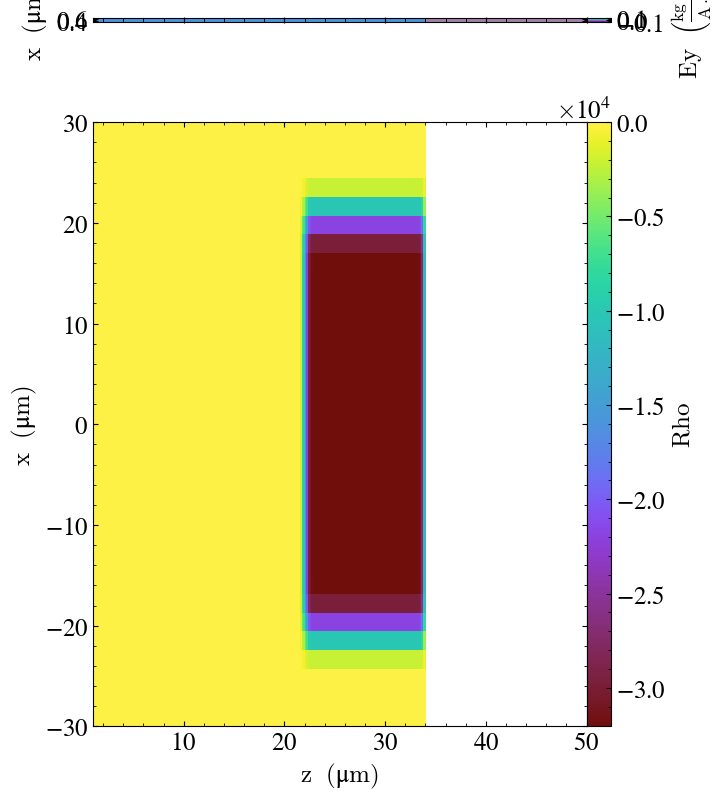

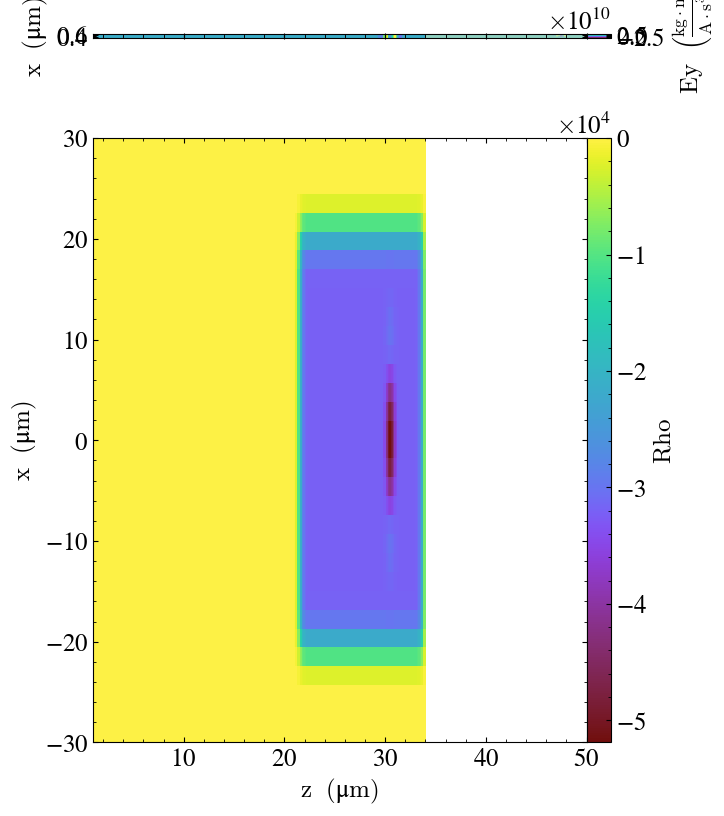

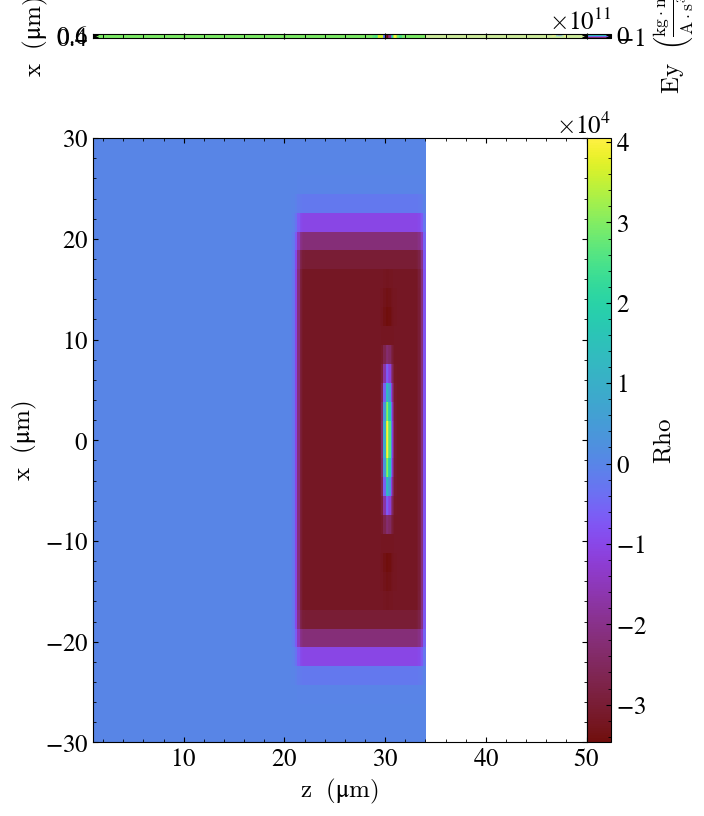

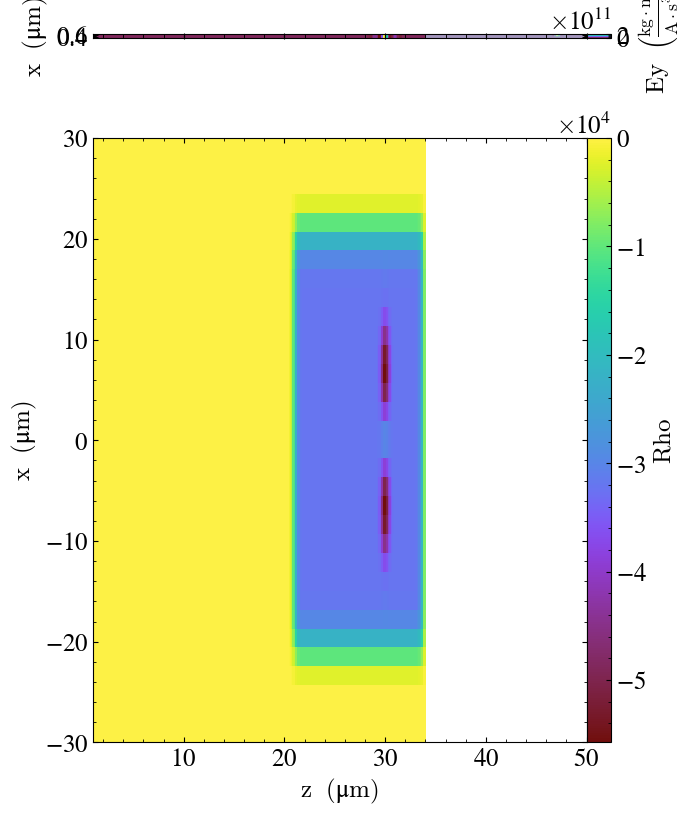

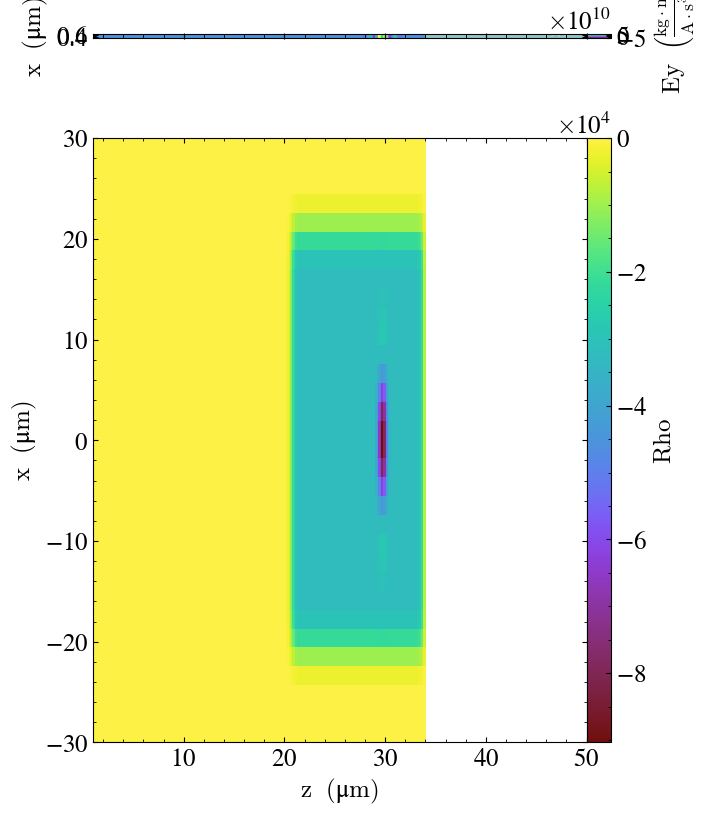

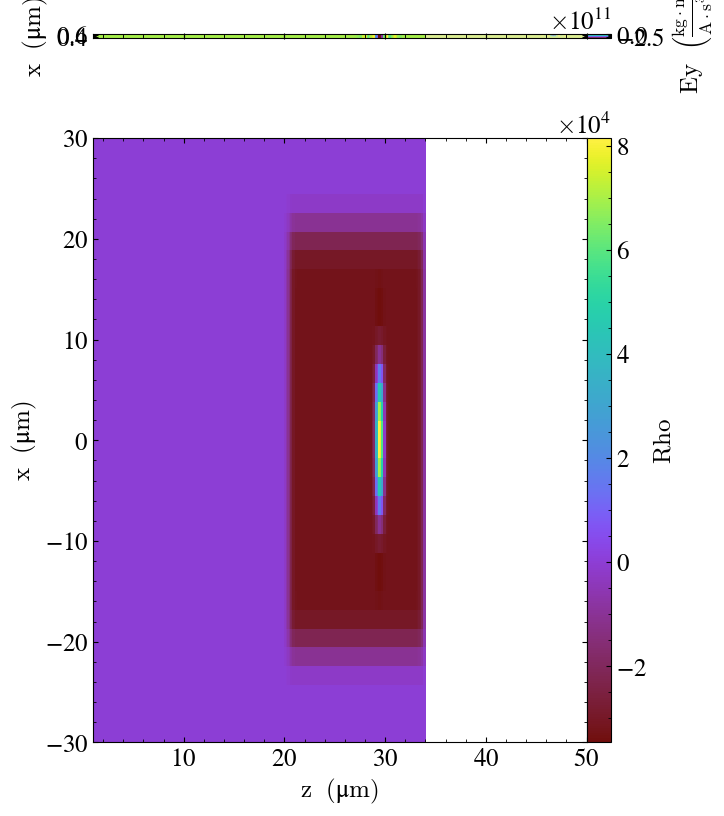

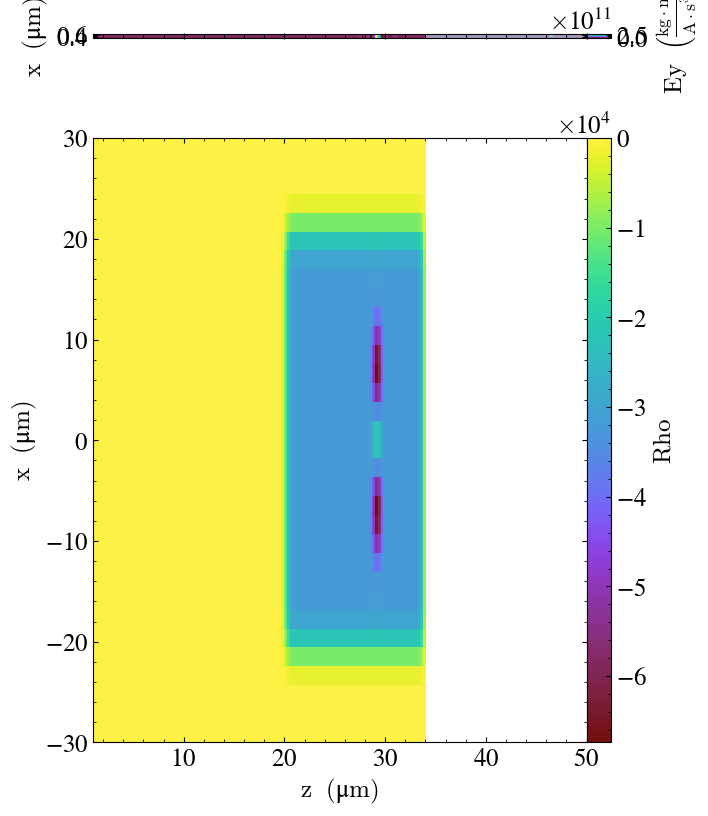

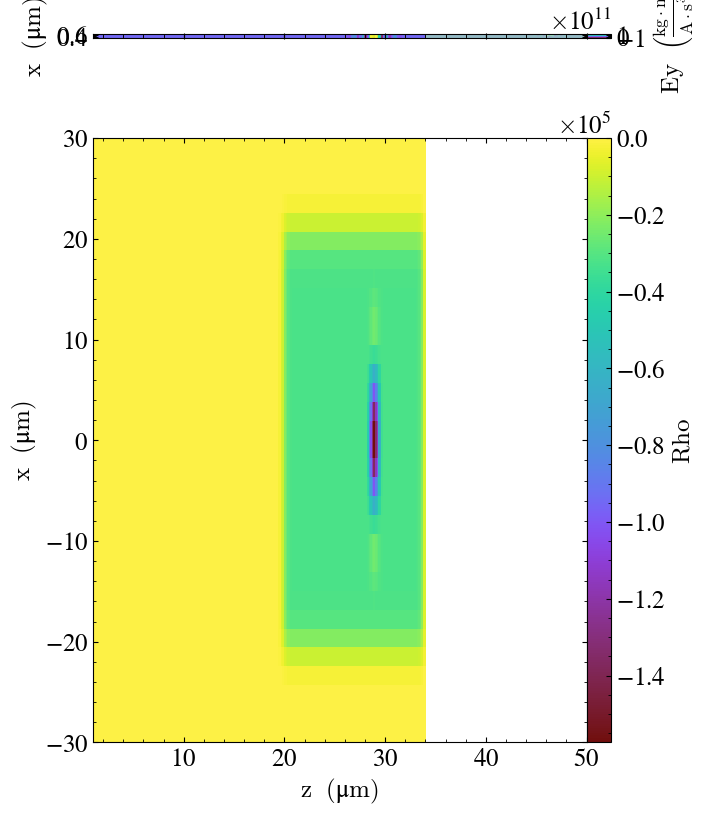

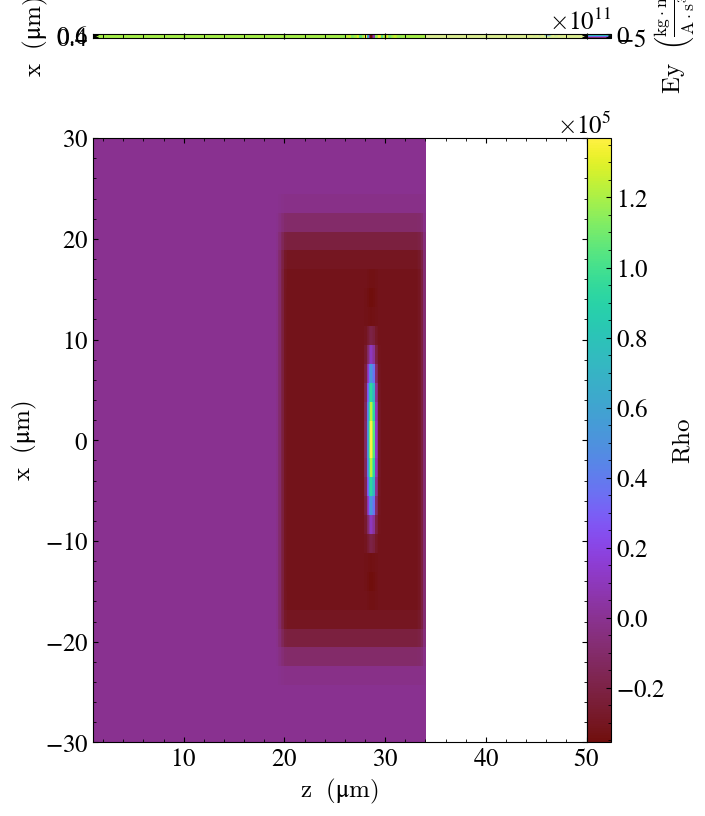

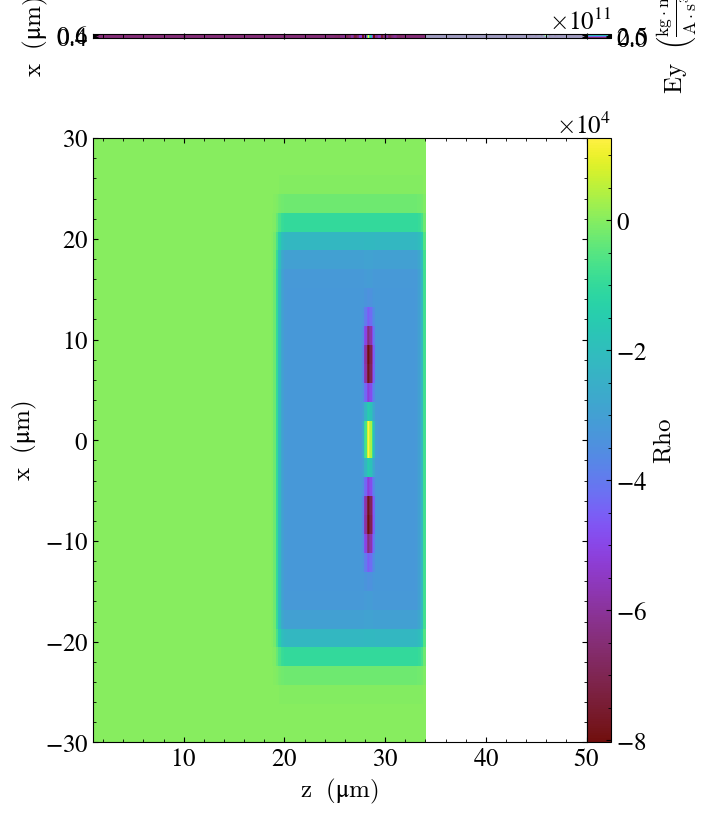

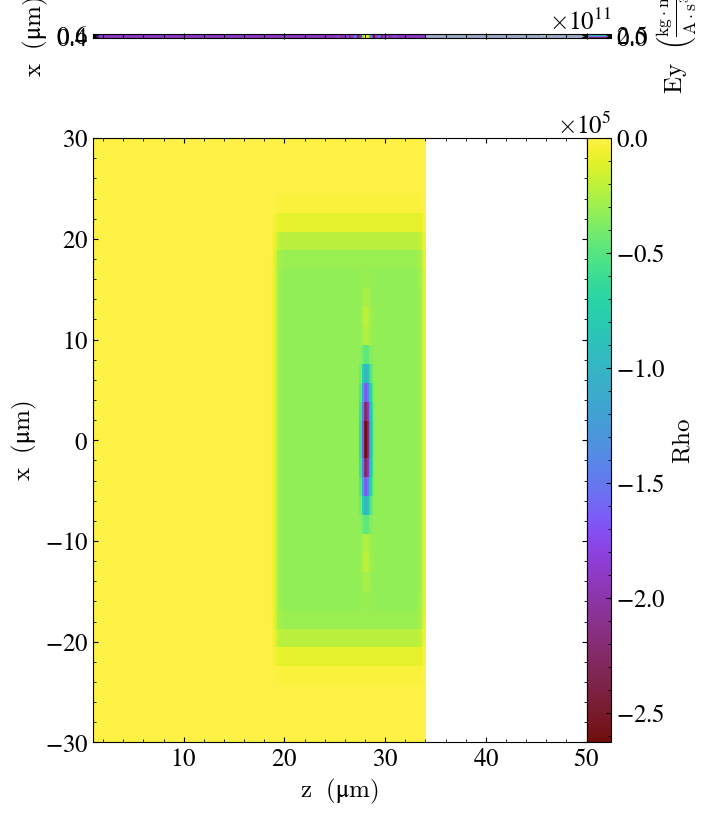

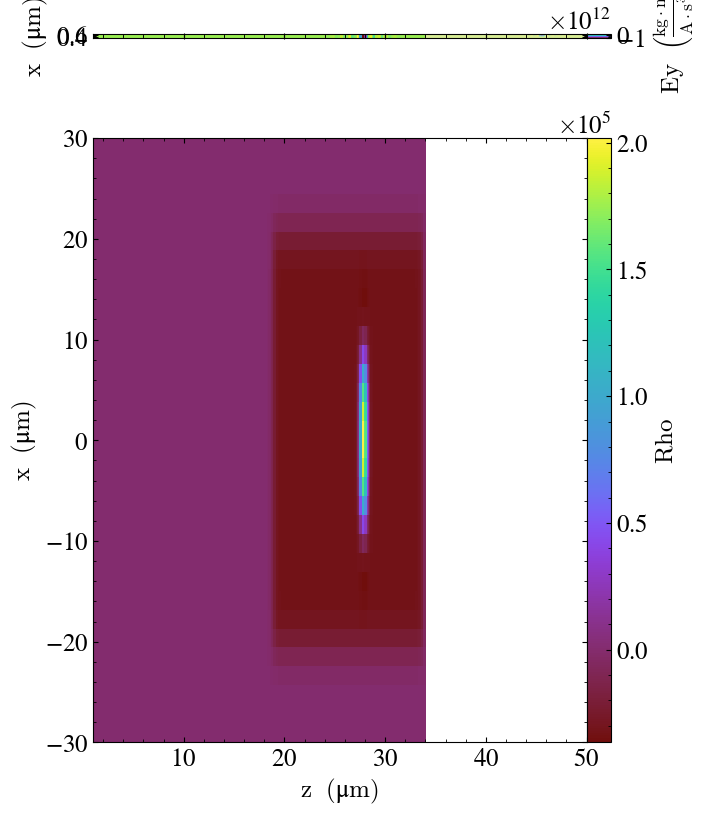

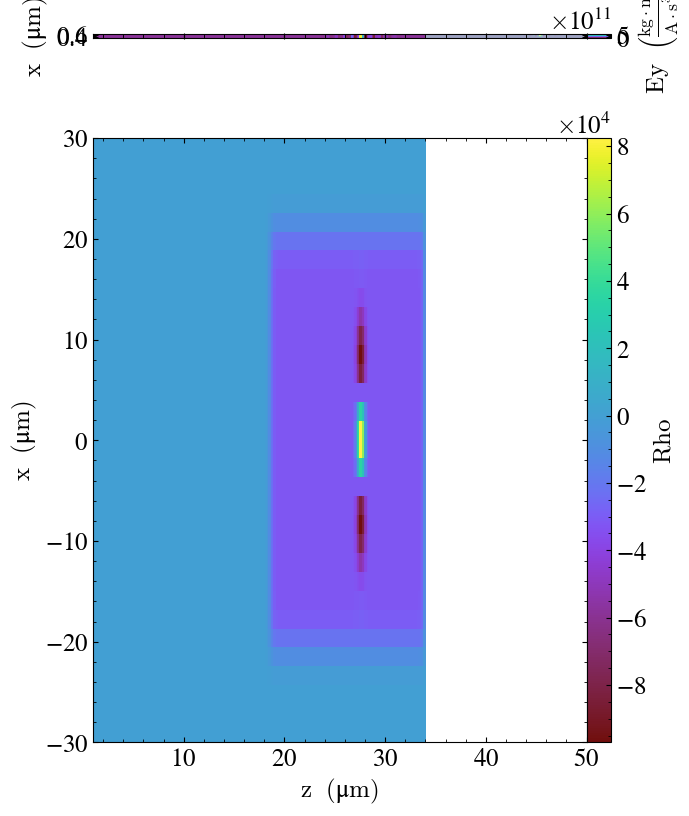

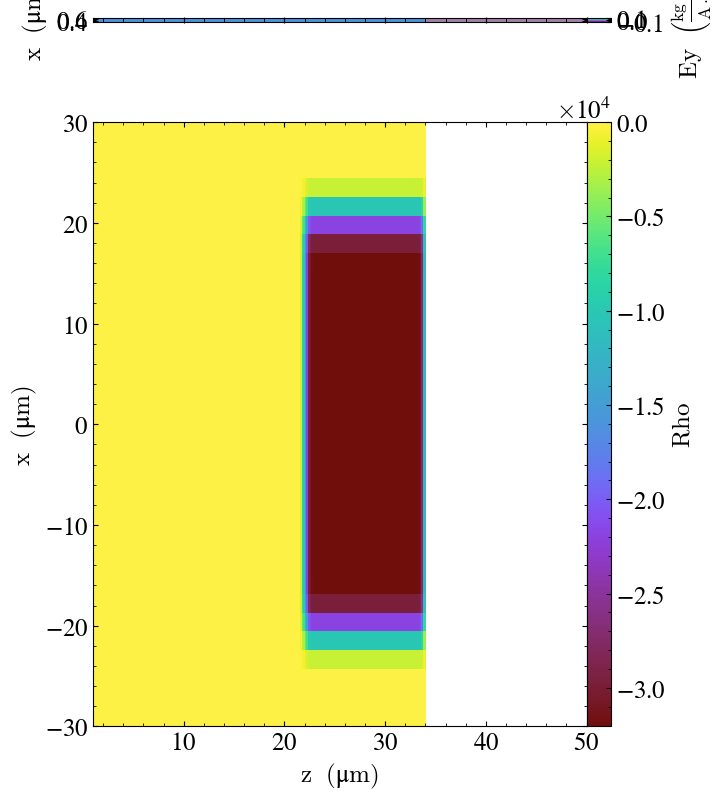

In [21]:
#!/usr/bin/env python3

# Copyright 2023 The WarpX Community
#
# This file is part of WarpX.
#
# Authors: Axel Huebl
# License: BSD-3-Clause-LBNL
#
# This is a script plots the wakefield of an LWFA simulation.

import sys
import os 
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
import yt

yt.funcs.mylog.setLevel(50)

fig, ax = plt.subplots()  # plt.subplots() creates a new figure and ax is a variable set to it
file_index = 0
file_list = []

def ani(file_index):
    ims = []  # a list of lists in which each index is a frame of the animation
    
    global file_list
    
    fn = file_list[file_index]  # give file name to variable 'fn' stands for 'file name'

    # Read the file
    ds = yt.load(fn)  # load the above file into variable ds

    # plot the laser field and absolute density
    fields = ["Ey", "rho"]  # a list of fields representing physical quantities. Here it is electric field and density
    normal = "y"  # this is the axis that is perpendicular to the 2D plane
    sl = yt.SlicePlot(ds, normal=normal, fields=fields)  # make this thing 2D
    for field in fields:  # go through the list of physical quantities
        sl.set_log(field, False)  # don't do any logarithmic scaling
        
    sl.set_figure_size((4, 8))  # sets the dimensions of the figure height of 4in width of 8in
    fig = sl.export_to_mpl_figure(nrows_ncols=(2, 1))  # converts sl SlicePlot object into a matplotlib figure. A matplotlib fig is like a canvas to display stuff on
        
    ax = fig.axes[0]  # accessing the first subplot from the grid of subplots (top left?)
        
    # Get the image data from the subplot
    image_data = ax.images[0].get_array()  # display data as an image, i.e., on a 2D regular raster.
    
    frame = ax.imshow(image_data, aspect='auto', extent=(1,50,0.3,0.7), alpha=0.5, origin='upper', zorder=-1)
    ims.append([frame])  # add created frames to the list of lists
        
    print(f"FILE #{file_index + 1} LOADED...")
        
    file_index += 1
    
    return ims


frame_number = 15
for i in range(frame_number):
    if i < 10:
        file_list.append(f"Python_LaserAcceleration_plt00000{i}")
    elif i >= 10 and i < 100:
        file_list.append(f"Python_LaserAcceleration_plt0000{i}")
    elif i >= 100 and i < 1000:
        file_list.append(f"Python_LaserAcceleration_plt000{i}")
    elif i >= 1000 and i < 10000:
        file_list.append(f"Python_LaserAcceleration_plt00{i}")
    elif i >= 10000 and i < 100000:
        file_list.append(f"Python_LaserAcceleration_plt0{i}")


animate = animation.FuncAnimation(fig, ani, frames=120, interval=250, repeat=False)
    
print("Frame gathering complete!")    
    
animate.save("plasma_sim_2D.mp4")

plt.show()  # display the animation


Frame gathering complete!


<Figure size 670x920 with 0 Axes>

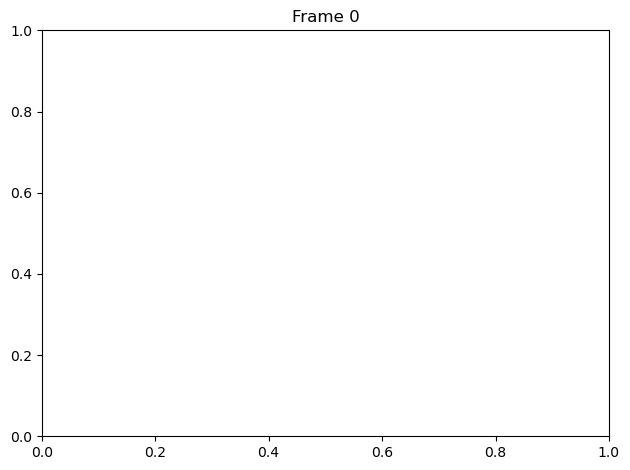

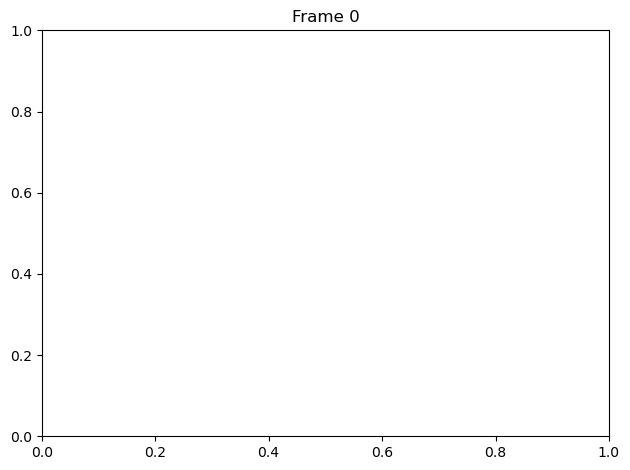

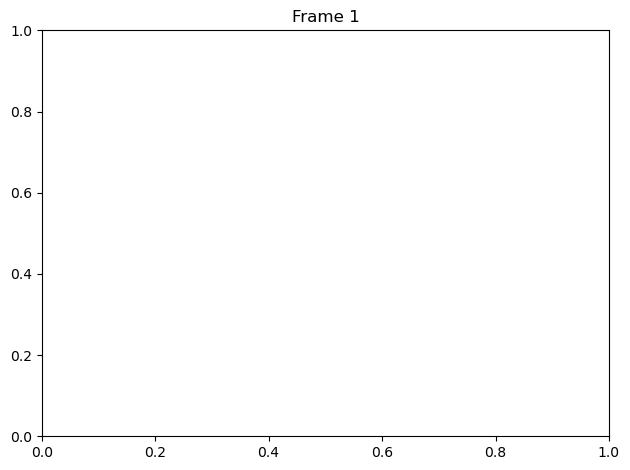

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '670x920', '-pix_fmt', 'rgba', '-framerate', '4.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'plasma_sim_2D.mp4']' returned non-zero exit status 255.

In [35]:
#!/usr/bin/env python3

# Copyright 2023 The WarpX Community
#
# This file is part of WarpX.
#
# Authors: Axel Huebl
# License: BSD-3-Clause-LBNL
#
# This is a script plots the wakefield of an LWFA simulation.

import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import yt

yt.funcs.mylog.setLevel(50)

def plot_lwfa(frame_number):
    im = []
    
    if frame_number < 10:
        fn = f"Python_LaserAcceleration_plt00000{frame_number}"
    elif frame_number >= 10 and frame_number < 100:
        fn = f"Python_LaserAcceleration_plt0000{frame_number}"
    elif frame_number >= 100 and frame_number < 1000:
        fn = f"Python_LaserAcceleration_plt000{frame_number}"
    elif frame_number >= 1000 and frame_number < 10000:
        fn = f"Python_LaserAcceleration_plt00{frame_number}"
    elif frame_number >= 10000 and frame_number < 100000:
        fn = f"Python_LaserAcceleration_plt0{frame_number}"
    elif frame_number >= 100000 and frame_number < 1000000:
        fn = f"Python_LaserAcceleration_plt{frame_number}"

    # Read the file
    ds = yt.load(fn)

    # plot the laser field and absolute density
    fields = ["Ey", "rho"]
    normal = "y"
    sl = yt.SlicePlot(ds, normal=normal, fields=fields)
    for field in fields:
        sl.set_log(field, False)

    sl.set_figure_size((4, 8))
    fig = sl.export_to_mpl_figure(nrows_ncols=(2, 1))
    fig.tight_layout()
    plt.show()
    # Export plot to matplotlib figure



file = 'Python_LaserAcceleration_plt000000'  # base file for setting up the fig???
ds = yt.load(file)
fields = ["Ey", "rho"]
normal = "y"
sl = yt.SlicePlot(ds, normal=normal, fields=fields)
for field in fields:
    sl.set_log(field, False)

sl.set_figure_size((4, 8))
fig = sl.export_to_mpl_figure(nrows_ncols=(2, 1))
fig.tight_layout()

animate = animation.FuncAnimation(fig, update, frames=120, interval=250, repeat=False)

print("Frame gathering complete!")    
    
animate.save("plasma_sim_2D.mp4")


yt : [INFO     ] 2024-07-10 12:05:28,913 Parameters: current_time              = 8.687655225973454e-14
yt : [INFO     ] 2024-07-10 12:05:28,913 Parameters: domain_dimensions         = [ 32  32 256]
yt : [INFO     ] 2024-07-10 12:05:28,914 Parameters: domain_left_edge          = [-3.000000e-05 -3.000000e-05 -2.996875e-05]
yt : [INFO     ] 2024-07-10 12:05:28,915 Parameters: domain_right_edge         = [3.000000e-05 3.000000e-05 3.803125e-05]
yt : [INFO     ] 2024-07-10 12:05:29,198 xlim = -0.000030 0.000038
yt : [INFO     ] 2024-07-10 12:05:29,198 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:29,200 xlim = -0.000030 0.000038
yt : [INFO     ] 2024-07-10 12:05:29,201 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:29,203 Making a fixed resolution buffer of (('mesh', 'Ey')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:29,830 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-07-10 12:05:29,831 Parameters: domain_dimensions         = [ 32  32 256]
yt

Python_LaserAcceleration_plt000000


yt : [INFO     ] 2024-07-10 12:05:30,104 xlim = -0.000056 0.000012
yt : [INFO     ] 2024-07-10 12:05:30,105 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:30,107 xlim = -0.000056 0.000012
yt : [INFO     ] 2024-07-10 12:05:30,107 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:30,109 Making a fixed resolution buffer of (('mesh', 'Ey')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:30,166 Making a fixed resolution buffer of (('boxlib', 'rho')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:31,554 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-07-10 12:05:31,554 Parameters: domain_dimensions         = [ 32  32 256]
yt : [INFO     ] 2024-07-10 12:05:31,555 Parameters: domain_left_edge          = [-3.0e-05 -3.0e-05 -5.6e-05]
yt : [INFO     ] 2024-07-10 12:05:31,555 Parameters: domain_right_edge         = [3.0e-05 3.0e-05 1.2e-05]


Python_LaserAcceleration_plt000000


yt : [INFO     ] 2024-07-10 12:05:31,814 xlim = -0.000056 0.000012
yt : [INFO     ] 2024-07-10 12:05:31,814 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:31,816 xlim = -0.000056 0.000012
yt : [INFO     ] 2024-07-10 12:05:31,816 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:31,818 Making a fixed resolution buffer of (('mesh', 'Ey')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:31,869 Making a fixed resolution buffer of (('boxlib', 'rho')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:32,626 Parameters: current_time              = 4.343827612986732e-15
yt : [INFO     ] 2024-07-10 12:05:32,626 Parameters: domain_dimensions         = [ 32  32 256]
yt : [INFO     ] 2024-07-10 12:05:32,627 Parameters: domain_left_edge          = [-3.00000e-05 -3.00000e-05 -5.49375e-05]
yt : [INFO     ] 2024-07-10 12:05:32,627 Parameters: domain_right_edge         = [3.00000e-05 3.00000e-05 1.30625e-05]


Python_LaserAcceleration_plt000005


yt : [INFO     ] 2024-07-10 12:05:32,885 xlim = -0.000055 0.000013
yt : [INFO     ] 2024-07-10 12:05:32,886 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:32,888 xlim = -0.000055 0.000013
yt : [INFO     ] 2024-07-10 12:05:32,888 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:32,890 Making a fixed resolution buffer of (('mesh', 'Ey')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:33,010 Making a fixed resolution buffer of (('boxlib', 'rho')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:33,816 Parameters: current_time              = 8.687655225973466e-15
yt : [INFO     ] 2024-07-10 12:05:33,817 Parameters: domain_dimensions         = [ 32  32 256]
yt : [INFO     ] 2024-07-10 12:05:33,817 Parameters: domain_left_edge          = [-3.0000000e-05 -3.0000000e-05 -5.3609375e-05]
yt : [INFO     ] 2024-07-10 12:05:33,818 Parameters: domain_right_edge         = [3.0000000e-05 3.0000000e-05 1.4390625e-05]


Python_LaserAcceleration_plt000010


yt : [INFO     ] 2024-07-10 12:05:34,632 xlim = -0.000054 0.000014
yt : [INFO     ] 2024-07-10 12:05:34,633 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:34,634 xlim = -0.000054 0.000014
yt : [INFO     ] 2024-07-10 12:05:34,635 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:34,636 Making a fixed resolution buffer of (('mesh', 'Ey')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:34,755 Making a fixed resolution buffer of (('boxlib', 'rho')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:35,567 Parameters: current_time              = 1.30314828389602e-14
yt : [INFO     ] 2024-07-10 12:05:35,568 Parameters: domain_dimensions         = [ 32  32 256]
yt : [INFO     ] 2024-07-10 12:05:35,568 Parameters: domain_left_edge          = [-3.000000e-05 -3.000000e-05 -5.228125e-05]
yt : [INFO     ] 2024-07-10 12:05:35,569 Parameters: domain_right_edge         = [3.000000e-05 3.000000e-05 1.571875e-05]


Python_LaserAcceleration_plt000015


yt : [INFO     ] 2024-07-10 12:05:35,813 xlim = -0.000052 0.000016
yt : [INFO     ] 2024-07-10 12:05:35,813 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:35,815 xlim = -0.000052 0.000016
yt : [INFO     ] 2024-07-10 12:05:35,815 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:35,817 Making a fixed resolution buffer of (('mesh', 'Ey')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:35,934 Making a fixed resolution buffer of (('boxlib', 'rho')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:36,668 Parameters: current_time              = 1.737531045194693e-14
yt : [INFO     ] 2024-07-10 12:05:36,669 Parameters: domain_dimensions         = [ 32  32 256]
yt : [INFO     ] 2024-07-10 12:05:36,670 Parameters: domain_left_edge          = [-3.0000000e-05 -3.0000000e-05 -5.0953125e-05]
yt : [INFO     ] 2024-07-10 12:05:36,670 Parameters: domain_right_edge         = [3.0000000e-05 3.0000000e-05 1.7046875e-05]


Python_LaserAcceleration_plt000020


yt : [INFO     ] 2024-07-10 12:05:36,914 xlim = -0.000051 0.000017
yt : [INFO     ] 2024-07-10 12:05:36,915 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:36,917 xlim = -0.000051 0.000017
yt : [INFO     ] 2024-07-10 12:05:36,917 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:36,919 Making a fixed resolution buffer of (('mesh', 'Ey')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:37,041 Making a fixed resolution buffer of (('boxlib', 'rho')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:38,550 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-07-10 12:05:38,551 Parameters: domain_dimensions         = [ 32  32 256]
yt : [INFO     ] 2024-07-10 12:05:38,551 Parameters: domain_left_edge          = [-3.0e-05 -3.0e-05 -5.6e-05]
yt : [INFO     ] 2024-07-10 12:05:38,552 Parameters: domain_right_edge         = [3.0e-05 3.0e-05 1.2e-05]


Python_LaserAcceleration_plt000000


yt : [INFO     ] 2024-07-10 12:05:38,796 xlim = -0.000056 0.000012
yt : [INFO     ] 2024-07-10 12:05:38,797 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:38,798 xlim = -0.000056 0.000012
yt : [INFO     ] 2024-07-10 12:05:38,799 ylim = -0.000030 0.000030
yt : [INFO     ] 2024-07-10 12:05:38,800 Making a fixed resolution buffer of (('mesh', 'Ey')) 800 by 800
yt : [INFO     ] 2024-07-10 12:05:38,848 Making a fixed resolution buffer of (('boxlib', 'rho')) 800 by 800


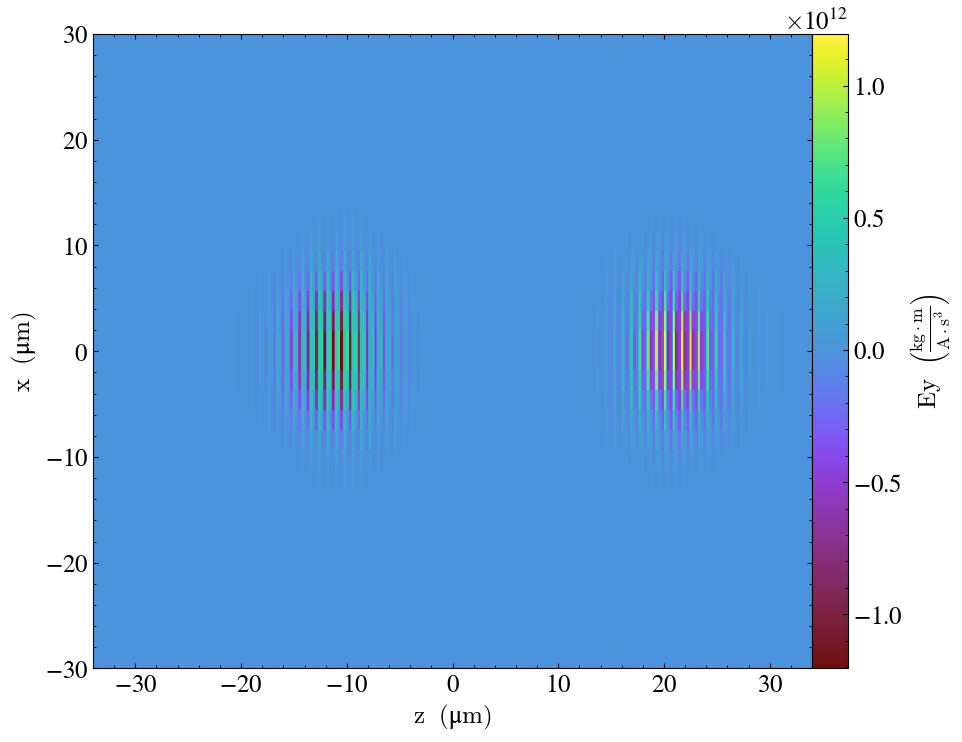

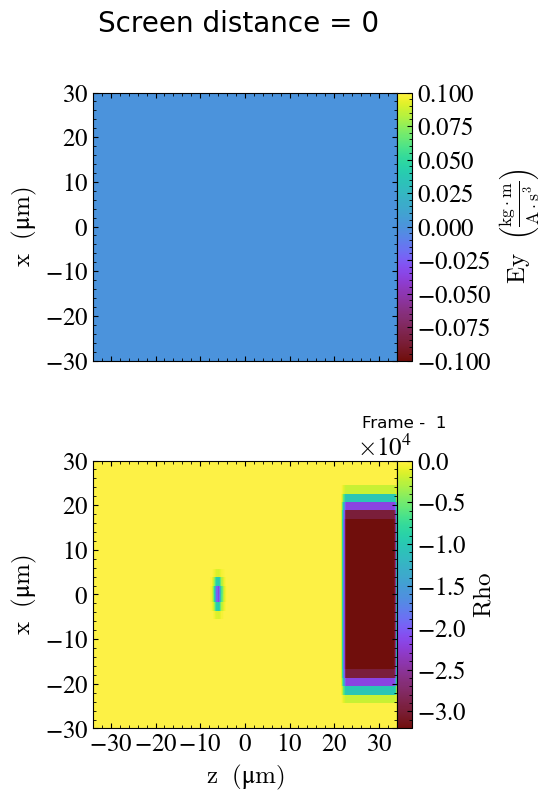

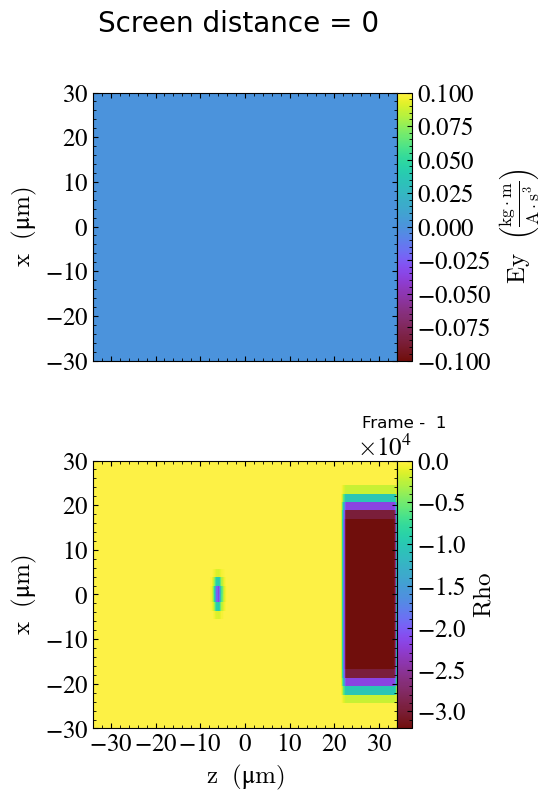

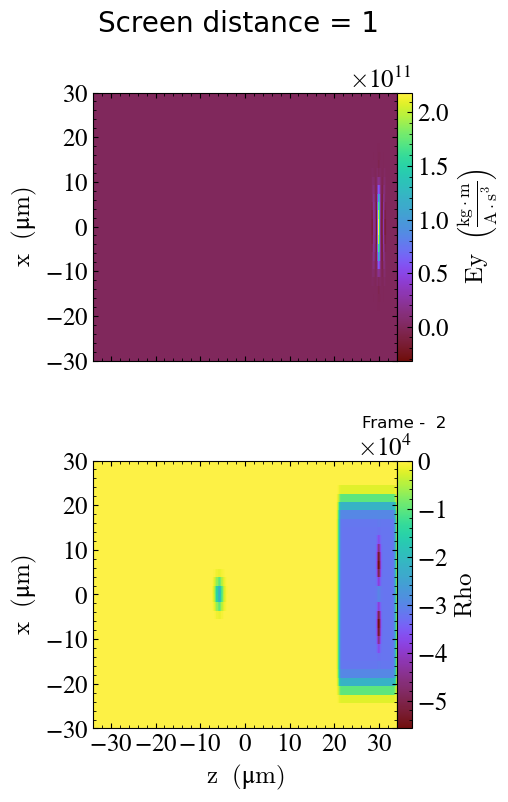

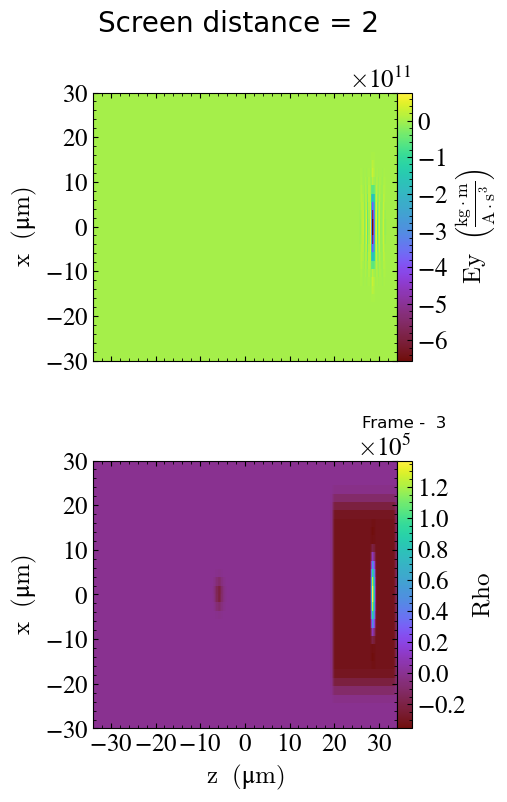

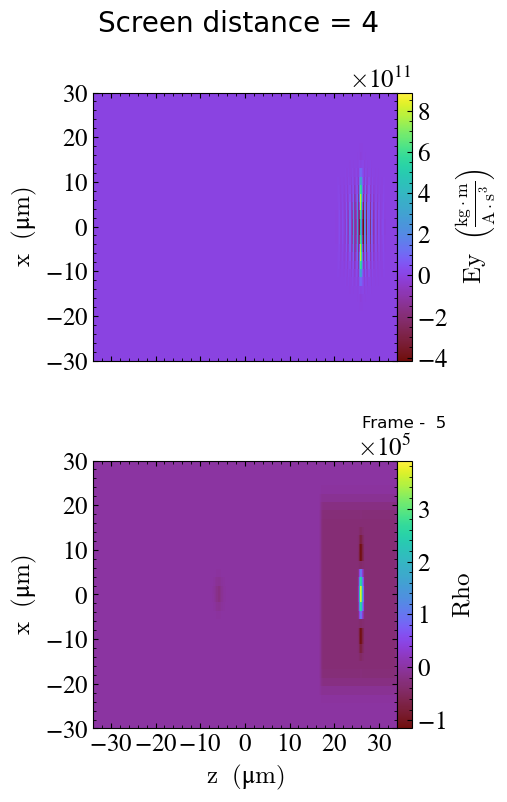

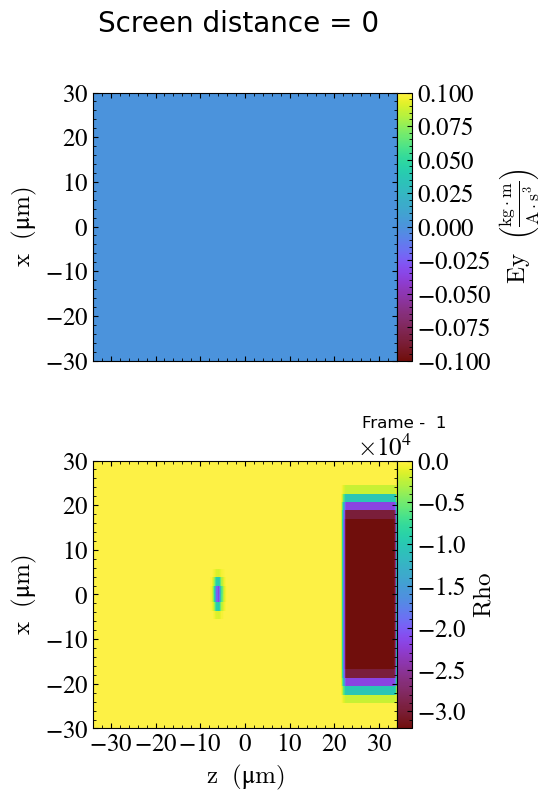

In [36]:
 def animate(i):
        file_list=f"Python_LaserAcceleration_plt000{format(i*5, '03')}"
    
        img = []  # a list of lists in which each index is a frame of the animation
    #for file_index in range(len(file_list)):
        print(file_list)
        # this will be the name of the plot file
        fn = file_list  # give file name to variable 'fn' stands for 'file name'
       
        # Read the file
        ds = yt.load(fn)  # load the above file into variable ds

        # plot the laser field and absolute density
        fields = ["Ey", "rho"]  # a list of fields representing physical quantities. Here it is electric field and density
        normal = "y"  # this is the axis that is perpendicular to the 2D plane
        ax = plt.gca()
        #plt.cla() 
        #ax.figure.canvas.draw()
        sl = yt.SlicePlot(ds, normal=normal, fields=fields)  # make this thing 2D
        for field in fields:  # go through the list of physical quantities
            sl.set_log(field, False)  # don't do any logarithmic scaling
       
       # sl.set_figure_size((4, 8))  # sets the dimensions of the figure height of 4in width of 8in
        
        fig = sl.export_to_mpl_figure(nrows_ncols=(2, 1))  # converts sl SlicePlot object into a matplotlib figure. A matplotlib fig is like a canvas to display stuff on
        fig.suptitle("Screen distance = " + str(i), fontsize=20)
        #plt.show()
        ax = plt.gca()
        ax.set_title("Frame -  " + str(i+1)  )
        imgs = [obj for obj in ax.get_children() if isinstance(obj, mpl.image.AxesImage)]
        return [imgs]

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return [img]

        
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

import numpy as np
from PIL import Image
import yt

#figsize=(12, 6)
#fig = plt.figure(figsize=figsize)
#plt.ion()


file_list=f"Python_LaserAcceleration_plt000100"
fn = file_list  # give file name to variable 'fn' stands for 'file name'
ds = yt.load(fn)  # load the above file into variable ds
fields = ["Ey"]  # a list of fields representing physical quantities. Here it is electric field and density
normal = "y"  # this is the axis that is perpendicular to the 2D plane
sl = yt.SlicePlot(ds, normal=normal, fields=fields)  # make this thing 2D
for field in fields:  # go through the list of physical quantities
    sl.set_log(field, False)  # don't do any logarithmic scaling

fig = sl.export_to_mpl_figure(nrows_ncols=(1, 1))  # converts sl SlicePlot object into a matplotlib figure. A matplotlib fig is like a canvas to display stuff on
#fig.suptitle("Screen distance = " + str(0), fontsize=20)
img = fig2img(fig)
#image_array = np.array(img)
#im = fig.imshow(img)
#img.show()
#draw_image  = ax.imshow(frames[0].get_array()
fps = 5
ani = animation.FuncAnimation(fig, animate, frames=5, interval=250, repeat=False)
#plt.show()
ani.save('Test1.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

In [12]:
allaxes = fig.get_axes()

In [18]:
allaxes[4]

IndexError: list index out of range

TypeError: Invalid shape (1, 825, 1085, 4) for image data